# [Dataset Description](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data)

# Data Preprocessing

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename) 
        print(path.ljust(100), os.path.getsize(path) // int(1e3), 'KB')

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv                                  393 KB
/kaggle/input/demand-forecasting-kernels-only/train.csv                                              17333 KB
/kaggle/input/demand-forecasting-kernels-only/test.csv                                               975 KB


In [3]:
dir_path = '/kaggle/input/demand-forecasting-kernels-only'
train = pd.read_csv(f'{dir_path}/train.csv')
test  = pd.read_csv(f'{dir_path}/test.csv')

In [4]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [6]:
print(f'train.shape: {train.shape}')
print(f'test.shape : {test.shape}')

train.shape: (913000, 4)
test.shape : (45000, 4)


In [7]:
target_feature = list(set(train.columns)-set(test.columns))[0]
target_feature

'sales'

In [8]:
def df_dtypes(df):
    pd.set_option('display.max_colwidth', None)

    df_dtypes = df.columns.groupby(df.dtypes)
    df_dtypes = pd.DataFrame({
        'dtype':     list(df_dtypes.keys()),
        '# columns': [len(df_dtypes[key])  for key in df_dtypes.keys()],
        'columns':   [list(df_dtypes[key]) for key in df_dtypes.keys()],
    })
    df_dtypes = df_dtypes.style.applymap(lambda x:'text-align: left', subset=['columns'])
    return df_dtypes

In [9]:
df_dtypes(train)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"
1,object,1,['date']


In [10]:
def compute_dtype(df):
    return [df[col].dtype                                              for col in df.columns]
def compute_count(df):
    return [df[col].count()                                            for col in df.columns]
def compute_mean(df, features):
    return [round(df[col].mean(), 1)        if col in features else '' for col in df.columns]
def compute_std(df, features):
    return [round(df[col].std(), 1)         if col in features else '' for col in df.columns]
def compute_min(df, features):
    return [round(df[col].min(), 1)         if col in features else '' for col in df.columns]
def compute_max(df, features):
    return [round(df[col].max(), 1)         if col in features else '' for col in df.columns]
def compute_quantile(df, features, percentage):
    return [round(df[col].quantile(percentage), 1) \
                                            if col in features else '' for col in df.columns]
def compute_IQR(df, features):
    return [round(df[col].max()-df[col].min(), 1) \
                                            if col in features else '' for col in df.columns]
def compute_nunique(df):
    return [df[col].nunique()                                          for col in df.columns]
def compute_unique(df, threshold):
    return [df[col].unique()  if df[col].nunique() < threshold else '' for col in df.columns]
def compute_mode(df):
    return [df[col].mode()[0]           if len(df[col].mode()) else '' for col in df.columns]
def compute_mode_count(df):
    return [df[col].value_counts().max()                               for col in df.columns]
def compute_mode_percentage(df):
    return [round(df[col].value_counts().max() * 100 / df.shape[0], 1) for col in df.columns]
def compute_null_count(df):
    return [df[col].isnull().sum()                                     for col in df.columns]
def compute_null_percentage(df):
    return [round(df[col].isnull().mean() * 100, 1)                    for col in df.columns]

In [11]:
def build_my_info_table(df, nunique_threshold=30):
    numerical_features = df.select_dtypes(include=[np.number])
    df_info = pd.DataFrame({
        '#':        np.arange(len(df.columns)),
        'column':   df.columns,
        'dtype':    compute_dtype(df),
        'count':    compute_count(df),
        'mean':     compute_mean(df, numerical_features),
        'std':      compute_std(df, numerical_features),
        'min':      compute_min(df, numerical_features),
        '25%':      compute_quantile(df, numerical_features, .25),
        '50%':      compute_quantile(df, numerical_features, .5),
        '75%':      compute_quantile(df, numerical_features, .75),
        'max':      compute_max(df, numerical_features),
        'IQR':      compute_IQR(df, numerical_features),
        'nunique':  compute_nunique(df),
        'unique':   compute_unique(df, nunique_threshold),
        'mode':     compute_mode(df),
        'mode #':   compute_mode_count(df),
        'mode %':   compute_mode_percentage(df),
        'null #':   compute_null_count(df),
        'null %':   compute_null_percentage(df),
    })
    df_info = df_info.sort_values(by='dtype')
    return df_info

In [12]:
build_my_info_table(train)

,#,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,nunique,unique,mode,mode #,mode %,null #,null %
1,1,store,int64,913000,5.5,2.9,1,3.0,5.5,8.0,10,9,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",1,91300,10.0,0,0.0
2,2,item,int64,913000,25.5,14.4,1,13.0,25.5,38.0,50,49,50,,1,18260,2.0,0,0.0
3,3,sales,int64,913000,52.3,28.8,0,30.0,47.0,70.0,231,231,213,,30,14283,1.6,0,0.0
0,0,date,object,913000,,,,,,,,,1826,,2013-01-01,500,0.1,0,0.0


In [13]:
def plot_bar_chart(df, x, y, xlabel, ylabel, title, xmin=None, xmax=None, palette='deep'):
    if df.shape[0] == 0:
        return
    size = (12, df.shape[0] / 4 + 1)
    plt.figure(figsize=size)
    sns.barplot(y=df[y], x=df[x], palette=palette)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if not xmin and not xmax:
        xmin, xmax = df[x].min(), df[x].max()
        xrange = (xmax - xmin) * .1
        xmin, xmax = xmin-xrange, xmax+xrange
    plt.xlim(xmin, xmax)
    plt.tight_layout()
    plt.show()

In [14]:
train_info = build_my_info_table(train)
nan_df = train_info[train_info['null %'] >= 10][['column', 'null %']].sort_values(by='null %')
plot_bar_chart(nan_df, x='null %', y='column', xlabel='Null Percentage %', ylabel='Feature', title='Null Percentage in each Feature', xmin=0, xmax=100, palette='coolwarm')

In [15]:
train = train.drop(columns=list(nan_df[nan_df['null %'] > 50]['column']))
test  = test.drop(columns=list(nan_df[nan_df['null %'] > 50]['column']))

In [16]:
test_info = build_my_info_table(test)
nan_df = test_info[test_info['null %'] >= 10][['column', 'null %']].sort_values(by='null %')
plot_bar_chart(nan_df, x='null %', y='column', xlabel='Null Percentage %', ylabel='Feature', title='Null Percentage in each Feature', xmin=0, xmax=100, palette='coolwarm')

In [17]:
train = train.drop(columns=list(nan_df[nan_df['null %'] > 50]['column']))
test  = test.drop(columns=list(nan_df[nan_df['null %'] > 50]['column']))

In [18]:
def fillna(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())
    categorical_features = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_features:
        df[col] = df[col].fillna(df[col].mode()[0])

def replace_inf(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns
    df[numerical_features] = df[numerical_features].replace([np.inf, -np.inf], np.nan)
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())

In [19]:
train = train.drop(columns=list(nan_df[nan_df['null %'] > 50]['column']))
test  = test.drop(columns=list(nan_df[nan_df['null %'] > 50]['column']))

In [20]:
def fillna(df):
    numerical_features   = df.select_dtypes(include=[np.number]).columns
    df[numerical_features]   = df[numerical_features].fillna(df[numerical_features].median())
    categorical_features = df.select_dtypes(exclude=[np.number]).columns
    for col in categorical_features:
        df[col] = df[col].fillna(df[col].mode()[0])

def replace_inf(df):
    numerical_features = df.select_dtypes(include=[np.number]).columns
    df[numerical_features] = df[numerical_features].replace([np.inf, -np.inf], np.nan)
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].median())

In [21]:
replace_inf(train)
replace_inf(test)
fillna(train)
fillna(test)

In [22]:
def get_categorical_features(df, nunique_threshold=30):
    all_df_columns = df.columns
    categorical_features = [col for col in all_df_columns if df[col].nunique() < nunique_threshold]
    return categorical_features

def get_numerical_features(df, nunique_threshold=30):
    numerical_df_columns = df.select_dtypes(include=[np.number]).columns
    numerical_features   = [col for col in numerical_df_columns if df[col].nunique() >= nunique_threshold]
    return numerical_features

In [23]:
categorical_features = get_categorical_features(train)
numerical_features   = get_numerical_features(train)
print(f'categorical_features: {len(categorical_features)}\n{categorical_features}\n')
print(f'numerical_features:   {len(numerical_features)}\n{numerical_features}\n')

categorical_features: 1
['store']

numerical_features:   2
['item', 'sales']



In [24]:
print(f'train.shape: {train.shape}')
print(f'test.shape : {test.shape}')

train.shape: (913000, 4)
test.shape : (45000, 4)


# Exploratory Data Analysis

In [25]:
# Distribution Plots:
def my_histplot(df, col, ax):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram Plot of {col}')
def my_distplot(df, col, ax):
    sns.distplot(df[col], ax=ax)
    ax.set_title(f'Distribution Plot of {col}')
def my_kdeplot(df, col, ax):
    sns.kdeplot(df[col], ax=ax, fill=True)
    ax.set_title(f'KDE Plot of {col}')
    
# Categorical Plots:
def my_pie_chart(df, col, ax):
    labels = df[col].value_counts()
    ax.pie(labels, labels=labels.index, autopct='%1.1f%%')
    ax.set_title(f'Pie Chart of {col}')
def my_countplot(df, col, ax):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(f'Count Plot of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
def my_boxplot(df, col, ax):
    sns.boxplot(y=df[col], ax=ax)
def my_violinplot(df, col, ax):
    sns.violinplot(y=df[col], ax=ax)
    
# Matrix Plots:
def my_heatmap(df, size, cmap, cbar_kws, font_size):
    plt.figure(figsize=size)
    sns.heatmap(df.corr(), annot=True, fmt=".1f", cmap=cmap, center=0, cbar_kws=cbar_kws, annot_kws={"size": font_size})
    plt.title('Correlation Heatmap')
    plt.show()

In [26]:
def plot_features(df, plot_funcs, width_ratios, height_ratios, n_col=1):
    def plot_feature(cols):
        n_plot_funcs = len(plot_funcs)
        fig = plt.figure(figsize=(sum(width_ratios), max(height_ratios)))
        gs = fig.add_gridspec(1, n_plot_funcs*n_col, width_ratios=width_ratios, height_ratios=height_ratios)
        axes = [0] * (n_plot_funcs * n_col)

        for i in range(n_col):
            for j in range(n_plot_funcs):
                k = i*n_plot_funcs+j
                axes[k] = fig.add_subplot(gs[0, k])
                plot_funcs[j](df, cols[i], axes[k])
                axes[k].set_xlabel(cols[i])

        plt.tight_layout()
        plt.show()
    
    for i in range(0, len(df.columns), n_col):
        plot_feature(df.columns[i:i+n_col])

In [27]:
def plot_numerical_features(df, plot_funcs=[my_boxplot, my_violinplot, my_distplot], width_ratios=[2, 2, 12], height_ratios=[4], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)

def plot_categorical_features(df, plot_funcs=[my_pie_chart, my_countplot], width_ratios=[5, 11], height_ratios=[5], n_col=1):
    plot_features(df, plot_funcs, width_ratios, height_ratios)

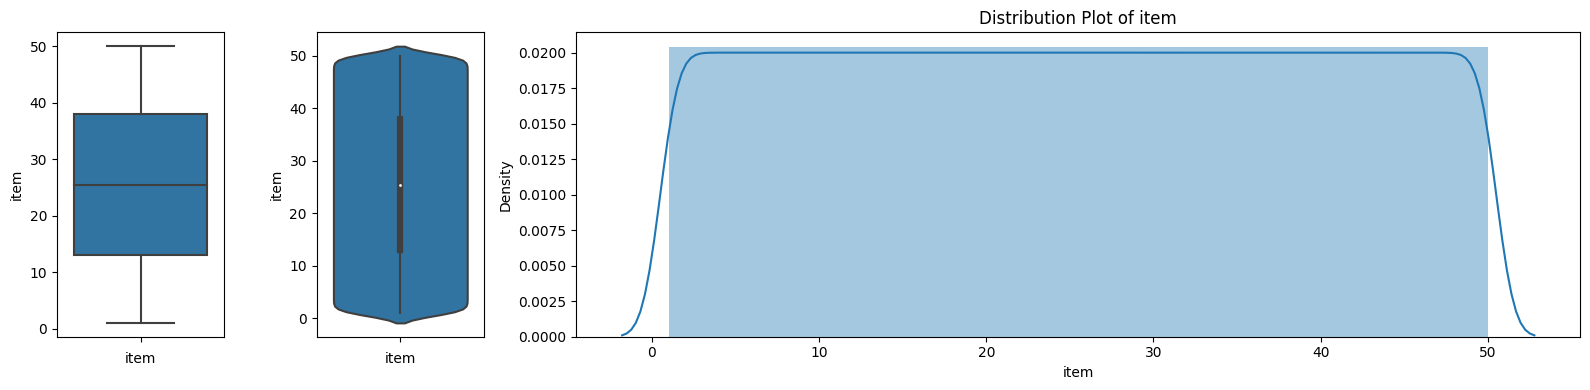

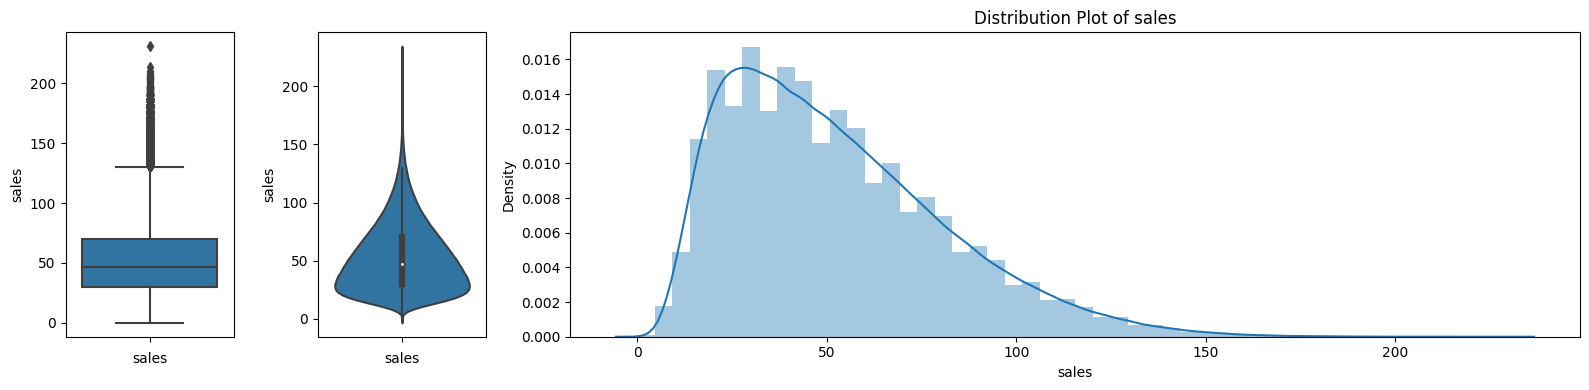

In [28]:
plot_numerical_features(train[numerical_features[:2]])

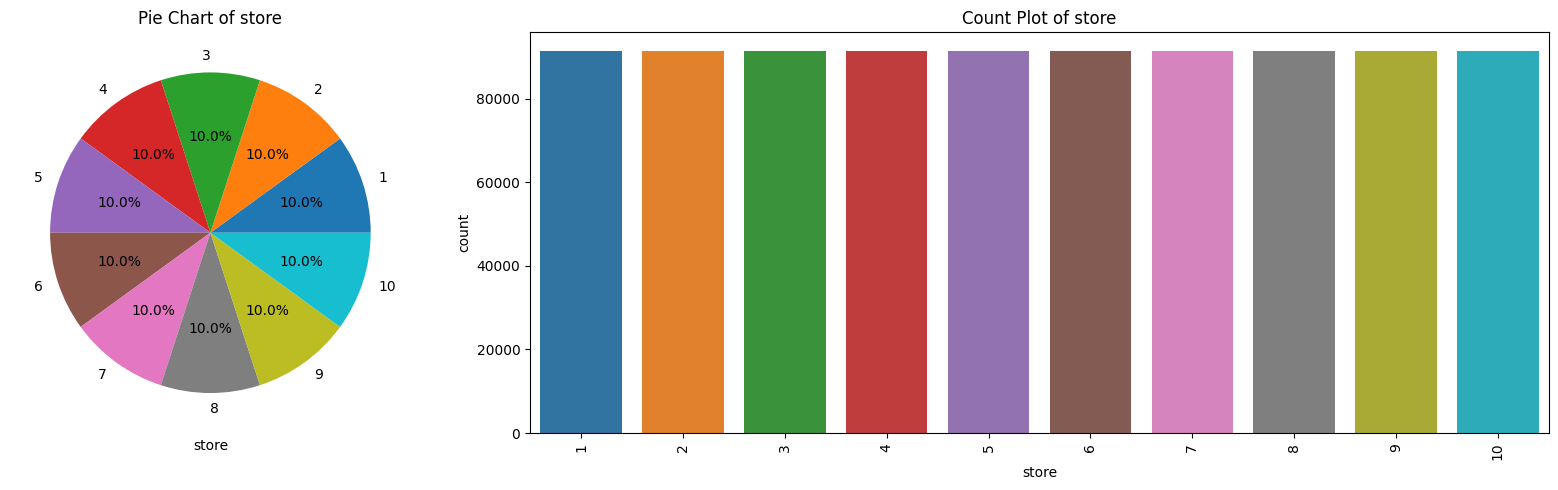

In [29]:
plot_categorical_features(train[categorical_features])

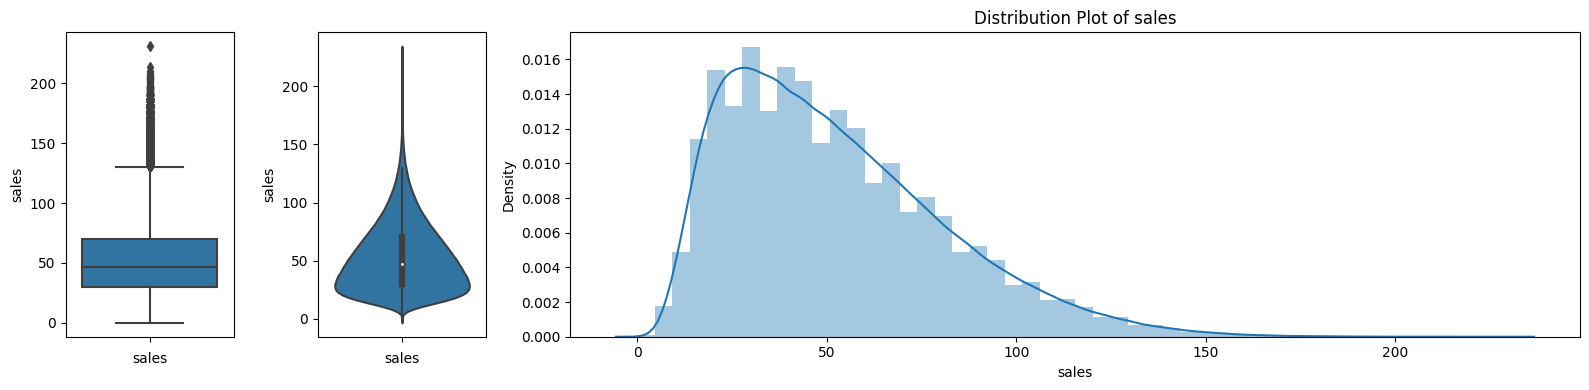

In [30]:
plot_numerical_features(train[[target_feature]])

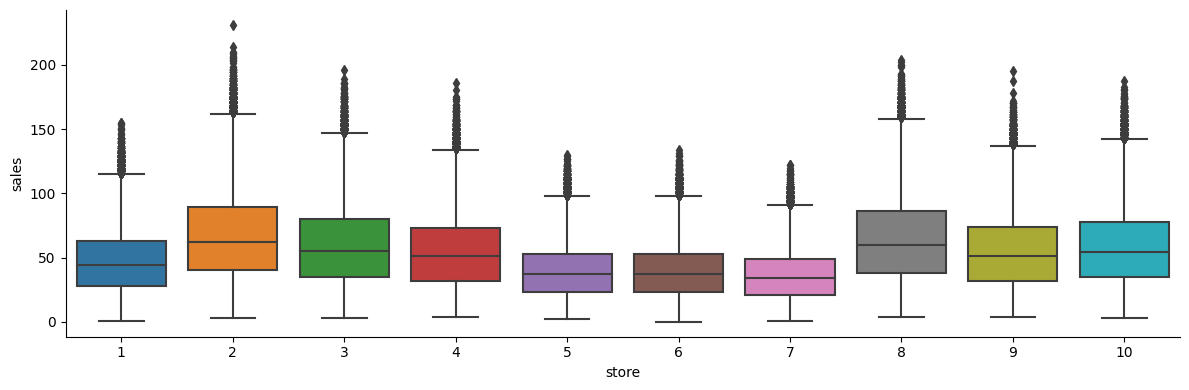

In [31]:
for cat_feature in categorical_features:
    sns.catplot(data=train, x=cat_feature, y=target_feature, kind='box', height=4, aspect=3)

In [32]:
def plot_features_correlation(df, features, target_feature, plot_kinds, step=6, height=3, aspect=1):
    df = df.sample(min(1000, df.shape[0]))
    for i in range(0, len(features), step):
        for plot_kind in plot_kinds:
            sns.pairplot(df, x_vars=features[i:i+step], y_vars=[target_feature], kind=plot_kind, height=height, aspect=aspect)

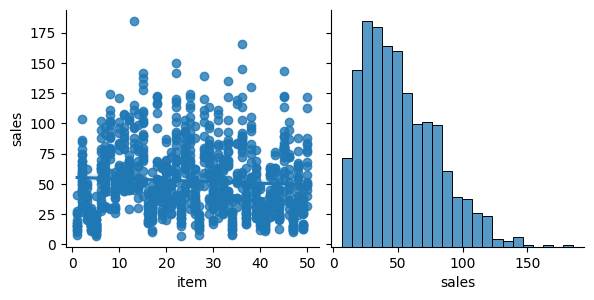

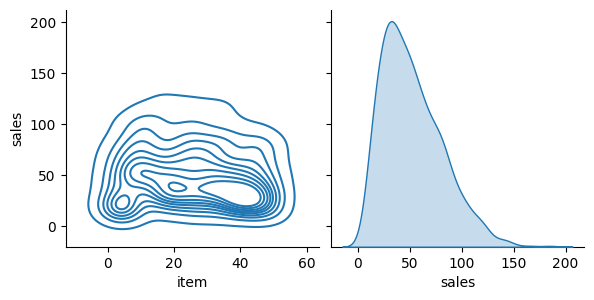

In [33]:
plot_features_correlation(train, numerical_features, target_feature, plot_kinds=['reg', 'kde'])

# Baseline Model

In [34]:
df_dtypes(train)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"
1,object,1,['date']


In [35]:
train_model1 = train.copy()
test_model1  = test.copy()

In [36]:
def drop_id_feature(df, id_col='id'):
    if id_col not in df.columns:
        return df, None
    df_id = df[id_col]
    df = df.drop(columns=[id_col])
    return df, df_id

In [37]:
train_model1, _ = drop_id_feature(train_model1)
test_model1, _  = drop_id_feature(test_model1)

In [38]:
from sklearn.preprocessing import LabelEncoder

def encode_str_features(df):
    categorical_features = get_categorical_features(df.select_dtypes(exclude=[np.number]))
    label_encoder = LabelEncoder()
    for col in categorical_features:
        df[col] = label_encoder.fit_transform(df[col])

In [39]:
encode_str_features(train_model1)
encode_str_features(test_model1)
df_dtypes(train_model1)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"
1,object,1,['date']


In [40]:
train_model1 = train_model1.drop(columns=train_model1.select_dtypes(exclude=[np.number]).columns)
test_model1  = test_model1.drop(columns=test_model1.select_dtypes(exclude=[np.number]).columns)
df_dtypes(train_model1)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"


In [41]:
from sklearn.metrics         import mean_absolute_error, \
                                    mean_squared_error, \
                                    mean_absolute_percentage_error, \
                                    median_absolute_error, \
                                    max_error, \
                                    r2_score, \
                                    explained_variance_score

def evaluate_model(y_test, y_pred):
    mae   = mean_absolute_error(y_test, y_pred)
    mse   = mean_squared_error(y_test, y_pred)
    mape  = mean_absolute_percentage_error(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)
    me    = max_error(y_test, y_pred)
    r2    = r2_score(y_test, y_pred)
    ev    = explained_variance_score(y_test, y_pred)

    result = {
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Mean Absolute Percentage Error': mape,
        'Median Absolute Error': medae,
        'Max Error': me,
        'R^2': r2,
        'Explained Variance': ev,
    }
    return result

In [42]:
from sklearn.linear_model    import LinearRegression, \
                                    Ridge

from sklearn.tree            import DecisionTreeRegressor
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.ensemble        import RandomForestRegressor

baseline_models = {
    'LinearRegression':          LinearRegression(),
    'Ridge':                     Ridge(),
    'DecisionTreeRegressor':     DecisionTreeRegressor(),
}
#    'RandomForestRegressor':     RandomForestRegressor(),
#    'KNeighborsRegressor':       KNeighborsRegressor(),

In [43]:
import time

def run_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        print(f'Model {name} begining now ...')
        begin_time = time.time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[name] = evaluate_model(y_test, y_pred)
        end_time = time.time()
        duration = round((end_time - begin_time) / 60, 2)
        print(f'Model {name} run in'.ljust(50), f'{duration} minutes')
    results = pd.DataFrame(results).T
    results = results.reset_index()
    results = results.rename(columns={'index': 'Model'})
    return results

In [44]:
from sklearn.model_selection import train_test_split

def split_data_train_test(df, target_feature, test_size=0.2):
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

In [45]:
X_train, X_test, y_train, y_test = split_data_train_test(train_model1, target_feature)

In [46]:
models_result1 = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.0 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.0 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.01 minutes


In [47]:
models_result1

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,LinearRegression,23.086237,825.196330,0.676935,20.584778,146.804471,0.003622,0.003626
1,Ridge,23.086237,825.196330,0.676935,20.584778,146.804471,0.003622,0.003626
2,DecisionTreeRegressor,11.886735,250.725655,0.271046,9.010338,92.263441,0.697263,0.697263


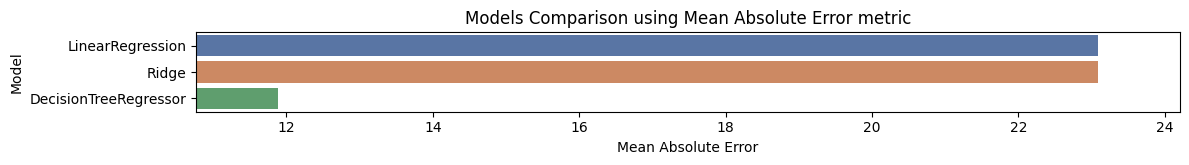

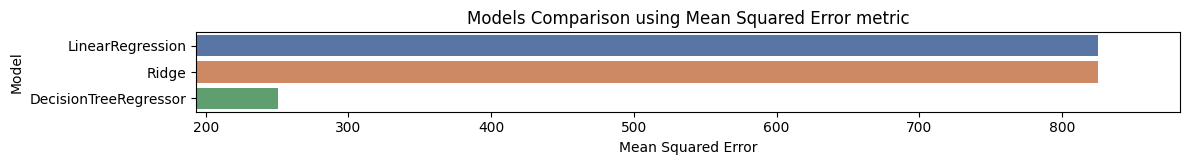

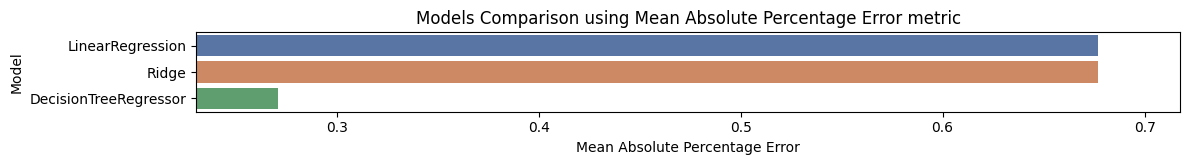

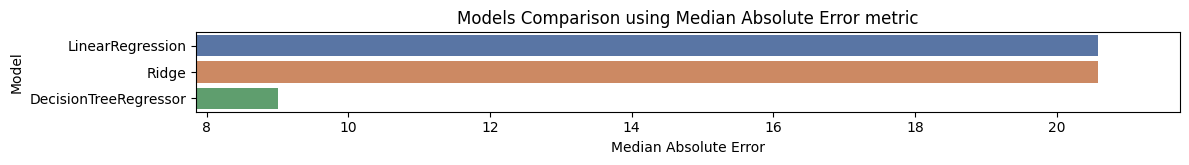

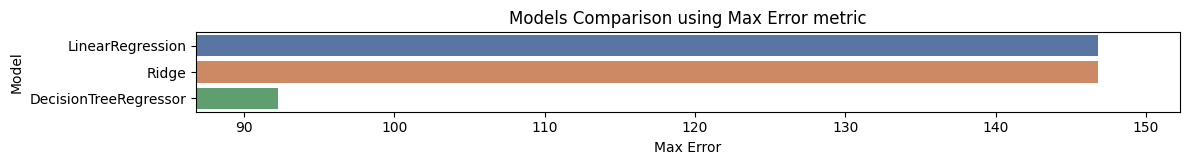

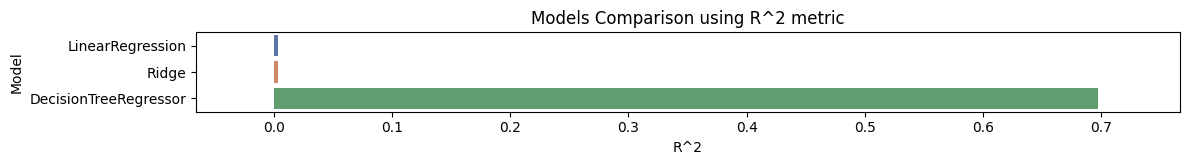

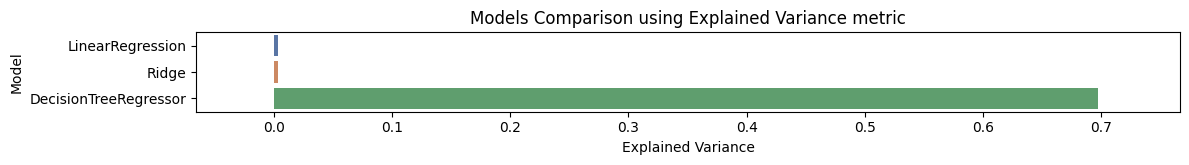

In [48]:
metrics = ['Mean Absolute Error', 'Mean Squared Error', 'Mean Absolute Percentage Error', 'Median Absolute Error', 'Max Error', 'R^2', 'Explained Variance']
for metric in metrics:
    plot_bar_chart(models_result1, x=metric, y='Model', xlabel=metric, ylabel='Model', title=f"Models Comparison using {metric} metric")

In [49]:
def get_best_model(results_df, models, metric):
    best_model_name = results_df.sort_values(by=[metric]).head(1)['Model'].iloc[0]
    best_model = models[best_model_name]
    return best_model

In [50]:
best_models1 = get_best_model(models_result1, baseline_models, 'Mean Squared Error')
print('Best Model of Baseline Models is:', best_models1.__class__.__name__)

Best Model of Baseline Models is: DecisionTreeRegressor


In [51]:
del train_model1, test_model1, X_train, X_test, y_train, y_test

# Feature Engineering and Selection

In [52]:
df_dtypes(train)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"
1,object,1,['date']


In [53]:
train.select_dtypes(include=[np.number]).head(10)

,store,item,sales
0,1,1,13
1,1,1,11
2,1,1,14
3,1,1,13
4,1,1,10
5,1,1,12
6,1,1,10
7,1,1,9
8,1,1,12
9,1,1,9


In [54]:
train.select_dtypes(exclude=[np.number]).head(10)

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
5,2013-01-06
6,2013-01-07
7,2013-01-08
8,2013-01-09
9,2013-01-10


In [55]:
build_my_info_table(train)

,#,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,nunique,unique,mode,mode #,mode %,null #,null %
1,1,store,int64,913000,5.5,2.9,1,3.0,5.5,8.0,10,9,10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",1,91300,10.0,0,0.0
2,2,item,int64,913000,25.5,14.4,1,13.0,25.5,38.0,50,49,50,,1,18260,2.0,0,0.0
3,3,sales,int64,913000,52.3,28.8,0,30.0,47.0,70.0,231,231,213,,30,14283,1.6,0,0.0
0,0,date,object,913000,,,,,,,,,1826,,2013-01-01,500,0.1,0,0.0


In [56]:
train_model2 = train.copy()
test_model2  = test.copy()

In [57]:
train_model2, _ = drop_id_feature(train_model2)
test_model2, _  = drop_id_feature(test_model2)

In [58]:
def extract_date(df, date_col):
    df[date_col]                     = pd.to_datetime(df[date_col])
    df[f'year {date_col}']           = df[date_col].dt.year.astype(int)
    df[f'month {date_col}']          = df[date_col].dt.month.astype(int)
    df[f'day {date_col}']            = df[date_col].dt.day.astype(int)
    df[f'day of week {date_col}']    = df[date_col].dt.dayofweek.astype(int)
    df[f'week of year {date_col}']   = df[date_col].dt.isocalendar().week.astype(int)
    df[f'quarter {date_col}']        = df[date_col].dt.quarter.astype(int)
    df[f'is weekend {date_col}']     = df[f'day of week {date_col}'].isin([5, 6]).astype(int)
    df[f'is leap year {date_col}']   = df[date_col].dt.is_leap_year.astype(int)
    df[f"is_month_end {date_col}"]   = df[date_col].dt.is_month_end.astype(int)
    df[f"is_month_start {date_col}"] = df[date_col].dt.is_month_start.astype(int)

def add_columns(df):
    df["store_item"]      = df["store"].astype(str) + "_" + df["item"].astype(str)
    start_date            = df["date"].min()
    df["days_from_start"] = (df["date"] - start_date).dt.days

In [59]:
extract_date(train_model2, 'date')
extract_date(test_model2, 'date')
add_columns(train_model2)
add_columns(test_model2)
df_dtypes(train_model2)

,dtype,# columns,columns
0,datetime64[ns],1,['date']
1,int64,14,"['store', 'item', 'sales', 'year date', 'month date', 'day date', 'day of week date', 'week of year date', 'quarter date', 'is weekend date', 'is leap year date', 'is_month_end date', 'is_month_start date', 'days_from_start']"
2,object,1,['store_item']


In [60]:
encode_str_features(train_model2)
encode_str_features(test_model2)
df_dtypes(train_model2)

,dtype,# columns,columns
0,datetime64[ns],1,['date']
1,int64,14,"['store', 'item', 'sales', 'year date', 'month date', 'day date', 'day of week date', 'week of year date', 'quarter date', 'is weekend date', 'is leap year date', 'is_month_end date', 'is_month_start date', 'days_from_start']"
2,object,1,['store_item']


In [61]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(df):
    categorical_features = get_categorical_features(df.select_dtypes(include=[np.number]))
    if target_feature in categorical_features:
        categorical_features.remove(target_feature)
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_features = encoder.fit_transform(df[categorical_features])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_features), index=df.index)
    df = df.drop(columns=categorical_features)
    df = pd.concat([df, encoded_df], axis=1)
    return df

In [62]:
train_model2 = train_model2.drop(columns=train_model2.select_dtypes(exclude=[np.number]).columns)
test_model2  = test_model2.drop(columns=test_model2.select_dtypes(exclude=[np.number]).columns)
df_dtypes(train_model2)

,dtype,# columns,columns
0,int64,14,"['store', 'item', 'sales', 'year date', 'month date', 'day date', 'day of week date', 'week of year date', 'quarter date', 'is weekend date', 'is leap year date', 'is_month_end date', 'is_month_start date', 'days_from_start']"


In [63]:
def get_skewed_features(df, threshold=0.25):
    numerical_features = get_numerical_features(df)
    skew_df = df[numerical_features].apply(lambda x: x.skew())
    skew_df = skew_df.sort_values(ascending=False)
    skew_df = skew_df.reset_index()
    skew_df.columns = ['Feature', 'SkewFactor']
    skewed_features = list(skew_df[abs(skew_df['SkewFactor']) > threshold]['Feature'])
    non_skewed_features = list(set(numerical_features)-set(skewed_features))
    return skewed_features, non_skewed_features, skew_df

In [64]:
from sklearn.preprocessing import StandardScaler

def transform_skewed_features(df, skewed_features):
    for col in skewed_features:
        df[col] = np.log1p(df[col])

standardScaler = StandardScaler()

def transform_non_skewed_features(df, non_skewed_features):
    for col in non_skewed_features:
        df[col] = standardScaler.fit_transform(df[[col]])

In [65]:
skewed_features, non_skewed_features, skew_df = get_skewed_features(train_model2)
print(f'skewed_features:     {len(skewed_features)}\n{skewed_features}\n')
print(f'non_skewed_features: {len(non_skewed_features)}\n{non_skewed_features}\n')

skewed_features:     1
['sales']

non_skewed_features: 4
['days_from_start', 'item', 'week of year date', 'day date']



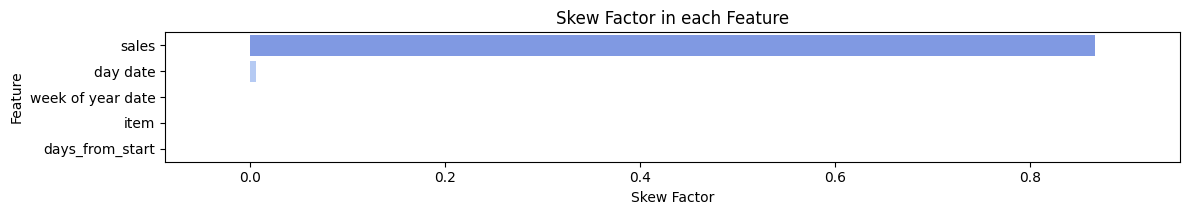

In [66]:
plot_bar_chart(skew_df, x='SkewFactor', y='Feature', xlabel='Skew Factor', ylabel='Feature', title='Skew Factor in each Feature', palette='coolwarm')

In [67]:
plot_features_correlation(train_model2, skewed_features[:-2], target_feature, plot_kinds=['kde', 'reg'])

In [68]:
transform_skewed_features(train_model2, skewed_features)

In [69]:
plot_features_correlation(train_model2, skewed_features[:-2], target_feature, plot_kinds=['kde', 'reg'])

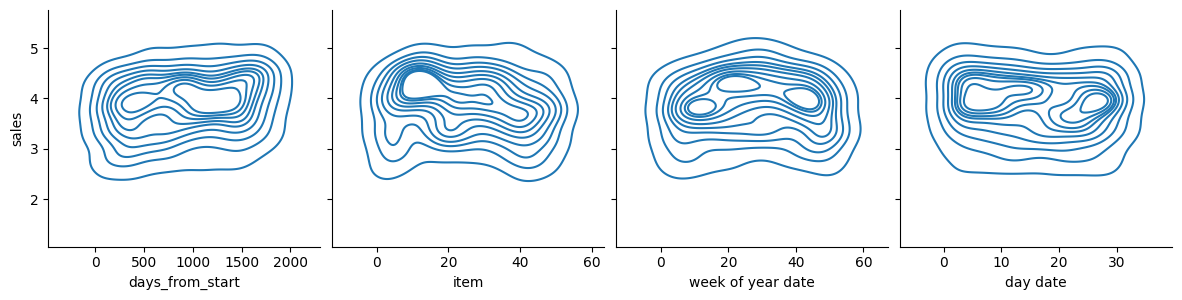

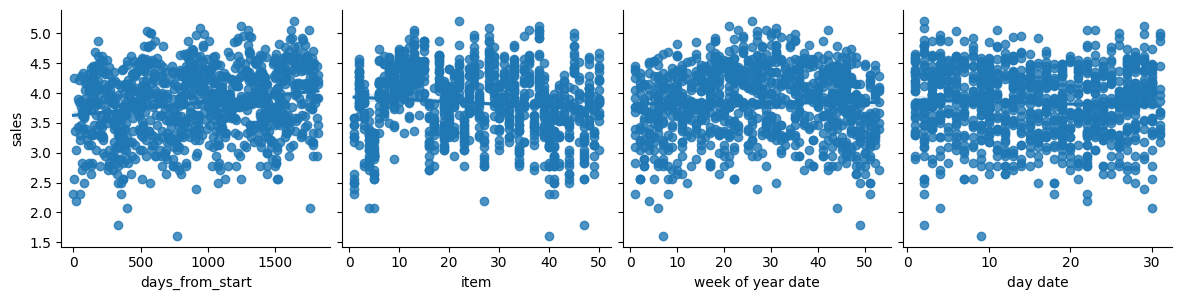

In [70]:
plot_features_correlation(train_model2, non_skewed_features[:], target_feature, plot_kinds=['kde', 'reg'])

In [71]:
transform_non_skewed_features(train_model2, non_skewed_features)

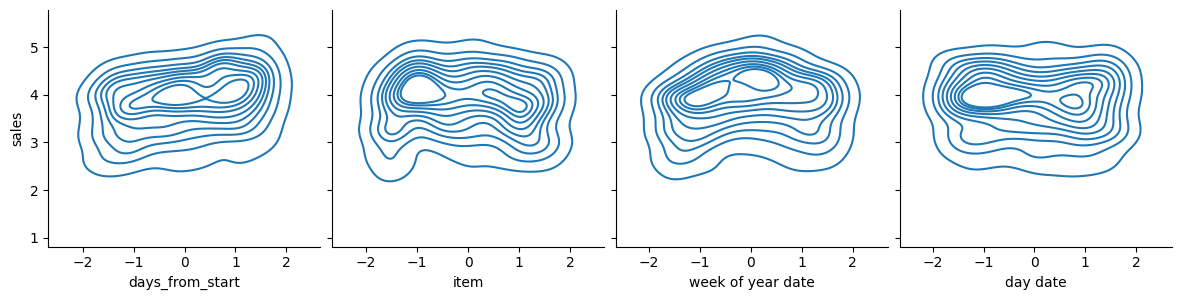

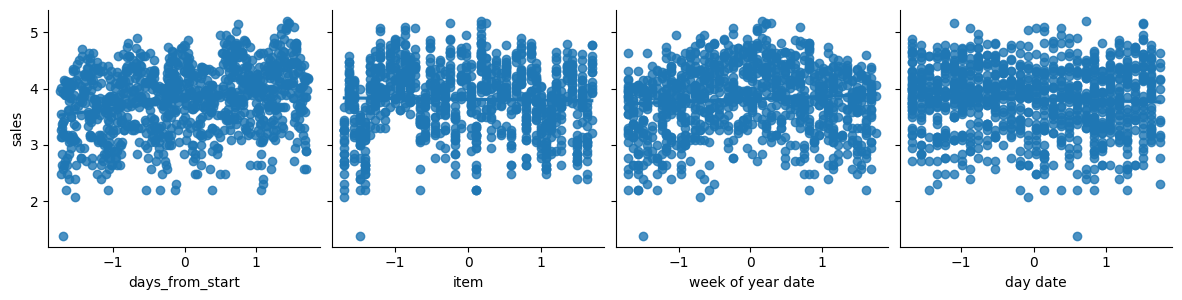

In [72]:
plot_features_correlation(train_model2, non_skewed_features[:], target_feature, plot_kinds=['kde', 'reg'])

In [73]:
skewed_features, non_skewed_features, skew_df = get_skewed_features(test_model2)
print(f'skewed_features:     {len(skewed_features)}\n{skewed_features}\n')
print(f'non_skewed_features: {len(non_skewed_features)}\n{non_skewed_features}\n')

skewed_features:     0
[]

non_skewed_features: 3
['days_from_start', 'item', 'day date']



In [74]:
transform_skewed_features(test_model2, skewed_features)
transform_non_skewed_features(test_model2, non_skewed_features)

# Enhanced Features Model

In [75]:
df_dtypes(train_model2)

,dtype,# columns,columns
0,int64,9,"['store', 'year date', 'month date', 'day of week date', 'quarter date', 'is weekend date', 'is leap year date', 'is_month_end date', 'is_month_start date']"
1,float64,5,"['item', 'sales', 'day date', 'week of year date', 'days_from_start']"


In [76]:
replace_inf(train_model2)
replace_inf(test_model2)
fillna(train_model2)
fillna(test_model2)

In [77]:
def split_data_X_y(df, target_feature):
    y = df[target_feature]
    X = df.drop(columns=[target_feature])
    return X, y

In [78]:
X, y = split_data_X_y(train_model2, target_feature)

In [79]:
from sklearn.feature_selection import mutual_info_regression

def feature_selection(X, y, mutual_info_method, top_n=10):
    mutual_info = mutual_info_method(X, y)
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'ImportanceFactor': mutual_info
    })
    importance_df = pd.DataFrame(importance_df, columns=['Feature', 'ImportanceFactor'])
    importance_df = importance_df.sort_values(by='ImportanceFactor', ascending=False)
    importance_df = importance_df.head(top_n)
    return importance_df

In [80]:
importance_df = feature_selection(X, y, mutual_info_regression)

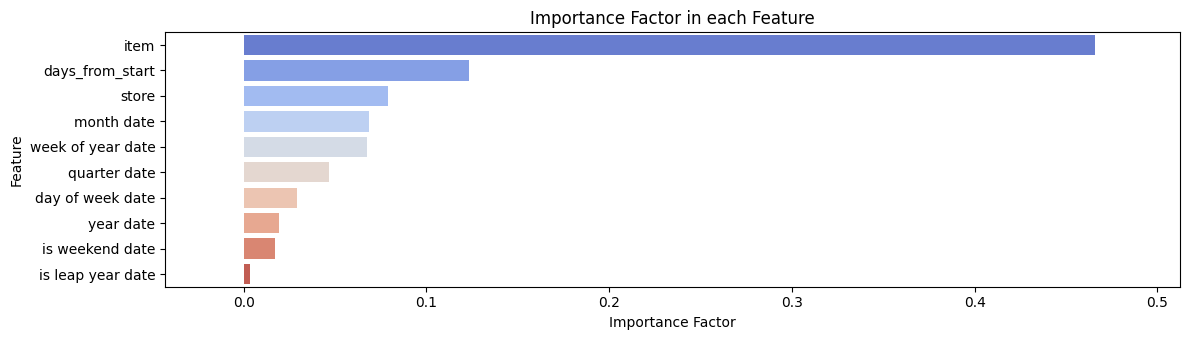

In [81]:
plot_bar_chart(importance_df, x='ImportanceFactor', y='Feature', xlabel='Importance Factor', ylabel='Feature', title='Importance Factor in each Feature', palette='coolwarm')

In [82]:
selected_features = importance_df['Feature']
X_selected  = X[selected_features]
test_model2 = test_model2[selected_features]
df_dtypes(X_selected)

,dtype,# columns,columns
0,int64,7,"['store', 'month date', 'quarter date', 'day of week date', 'year date', 'is weekend date', 'is leap year date']"
1,float64,3,"['item', 'days_from_start', 'week of year date']"


In [83]:
X_train_test_model2 = pd.concat([X_selected, test_model2])
X_train_test_model2 = one_hot_encoding(X_train_test_model2)
X_selected  = X_train_test_model2[:len(X_selected)]
test_model2 = X_train_test_model2[-len(test_model2):]
df_dtypes(X_selected)

,dtype,# columns,columns
0,float64,39,"['item', 'days_from_start', 'week of year date', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6', 'store_7', 'store_8', 'store_9', 'store_10', 'month date_2', 'month date_3', 'month date_4', 'month date_5', 'month date_6', 'month date_7', 'month date_8', 'month date_9', 'month date_10', 'month date_11', 'month date_12', 'quarter date_2', 'quarter date_3', 'quarter date_4', 'day of week date_1', 'day of week date_2', 'day of week date_3', 'day of week date_4', 'day of week date_5', 'day of week date_6', 'year date_2014', 'year date_2015', 'year date_2016', 'year date_2017', 'year date_2018', 'is weekend date_1', 'is leap year date_1']"


In [84]:
def get_target_correlations(df, target_feature):
    numerical_features  = df.select_dtypes(include=[np.number]).columns
    correlation_matrix  = df[numerical_features].corr()
    target_correlations = correlation_matrix[target_feature].sort_values(ascending=False)
    target_correlations = target_correlations.reset_index()
    target_correlations.columns = ['Feature', 'TargetCorrelation']
    return target_correlations

In [85]:
correlations_df = get_target_correlations(train_model2[list(selected_features)+[target_feature]], target_feature)

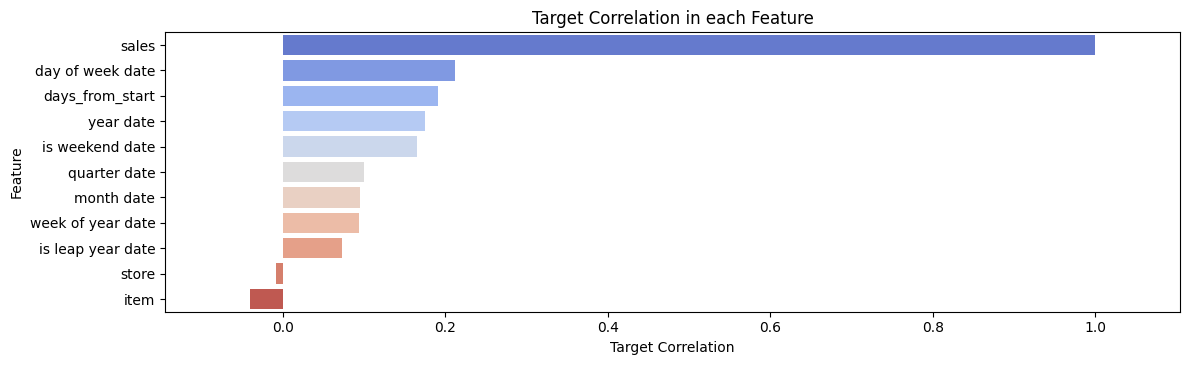

In [86]:
plot_bar_chart(correlations_df, x='TargetCorrelation', y='Feature', xlabel='Target Correlation', ylabel='Feature', title='Target Correlation in each Feature', palette='coolwarm')

In [87]:
from matplotlib.colors import LinearSegmentedColormap

def plot_heatmap(df, size_factor=1/2):
    df = df.select_dtypes(include=[np.number])
    height = int(len(df.columns) * size_factor)
    font_size = max(min(12, 119 // height), 8)
    cmap = LinearSegmentedColormap.from_list(
        'custom_diverging',
        ['blue', 'lightblue', 'white', 'lightcoral', 'red'],
        N=5
    )
    cbar_kws = {'ticks': [-1, -.5, 0, .5, 1]}
    my_heatmap(df, size=(height+1, height+1), cmap=cmap, cbar_kws=cbar_kws, font_size=font_size)

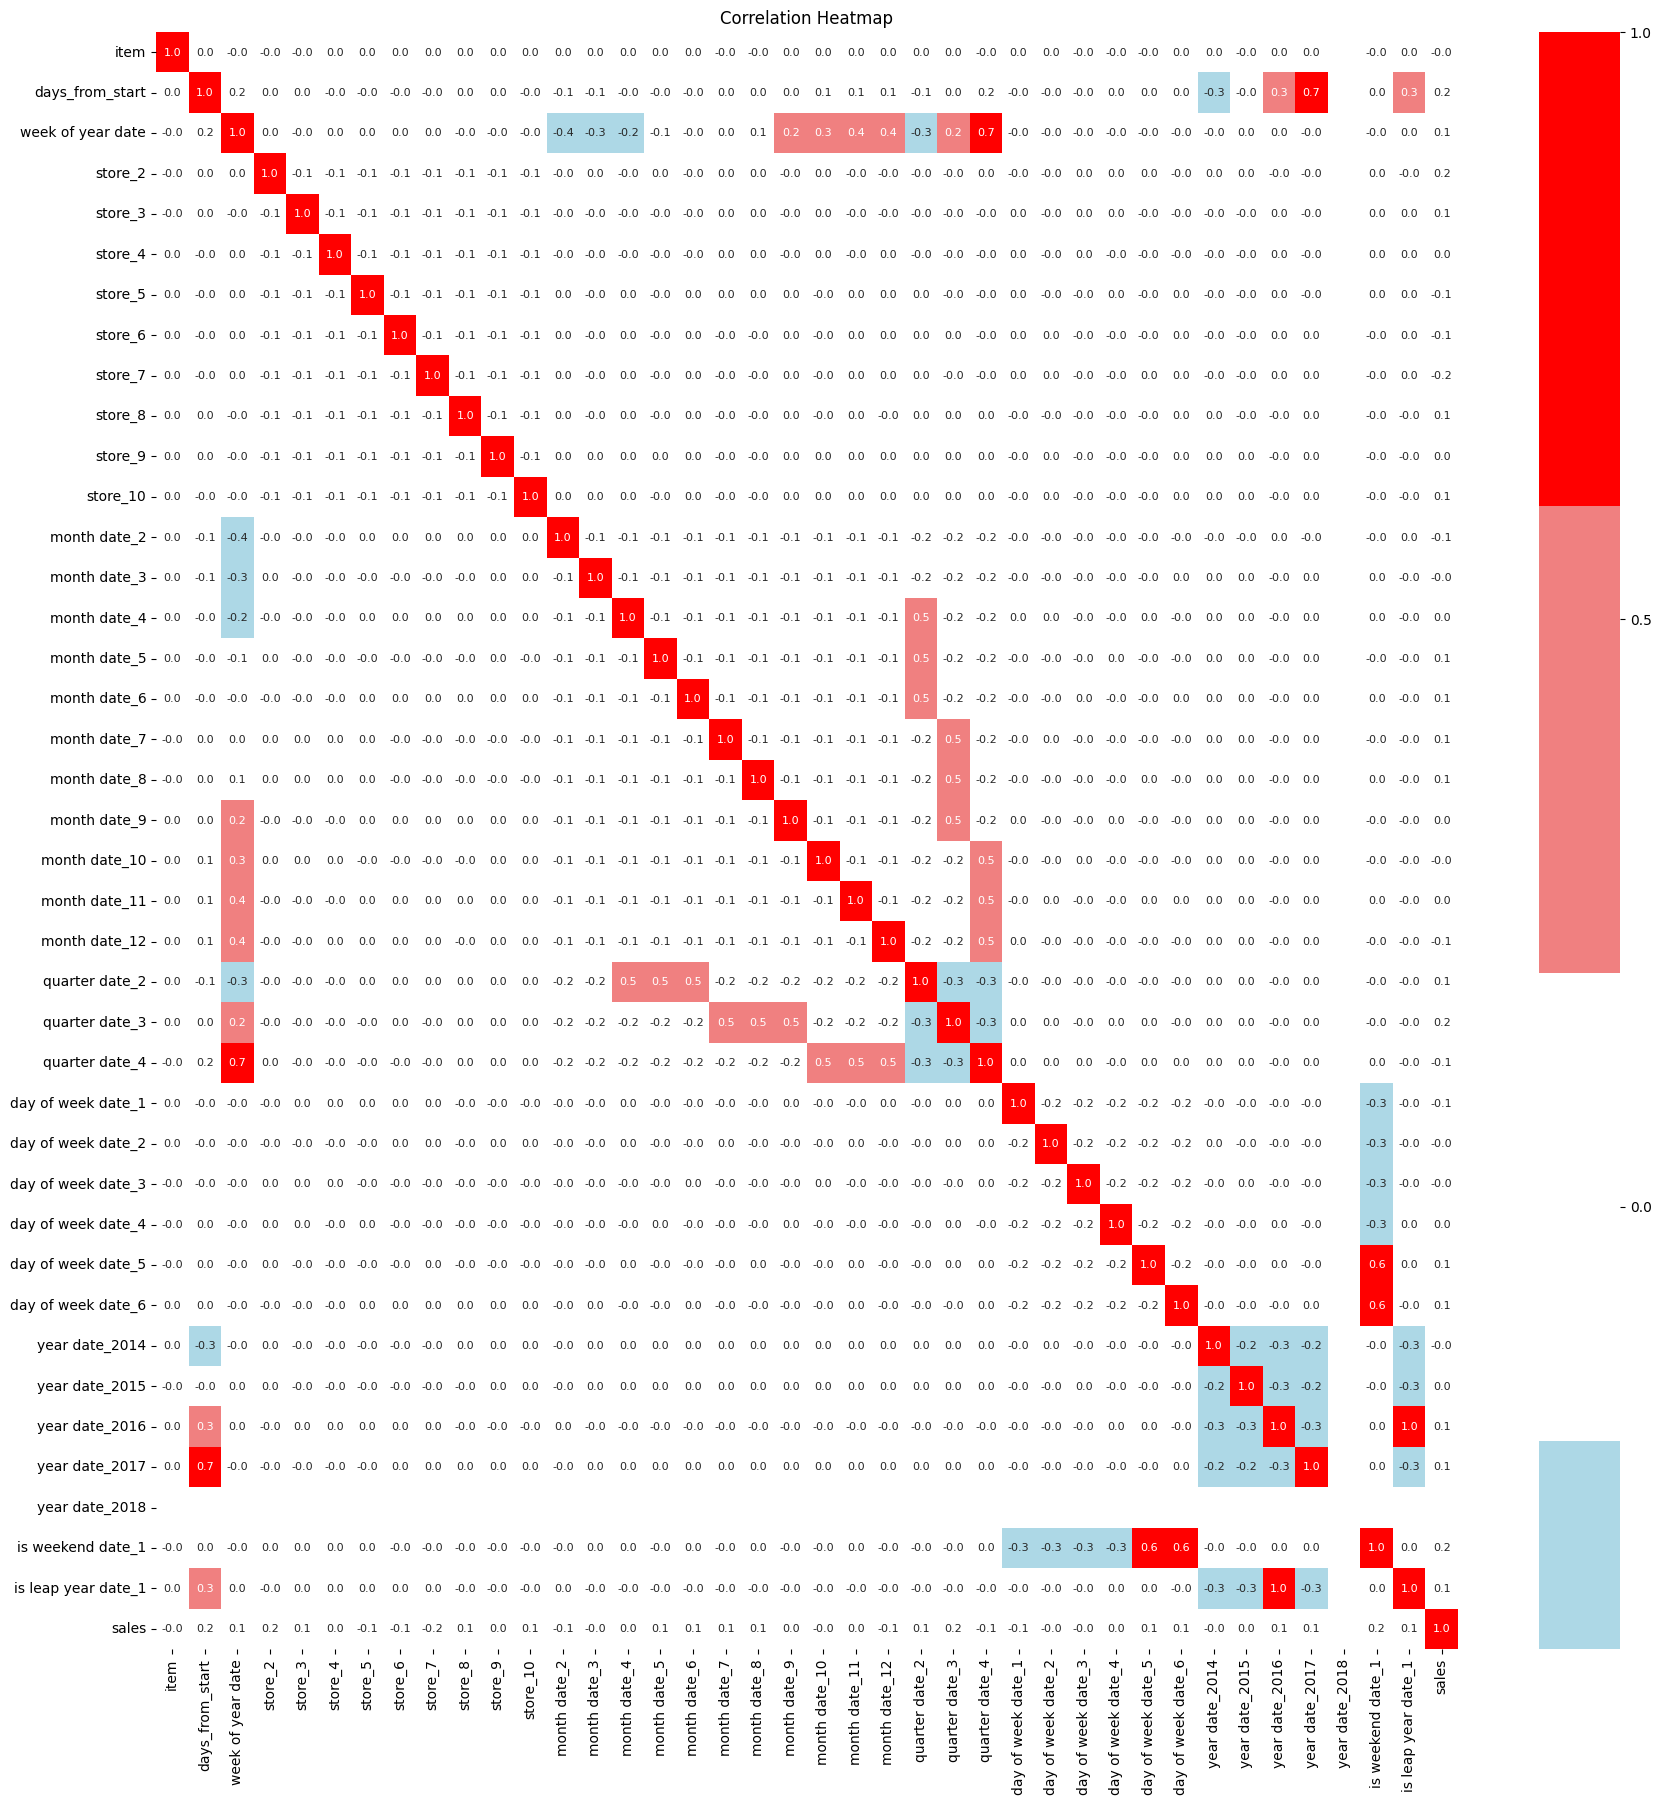

In [88]:
plot_heatmap(pd.concat([X_selected, y], axis=1))

In [89]:
X_train, X_test, y_train, y_test = split_data_train_test(pd.concat([X_selected, y], axis=1), target_feature)

In [90]:
models_result2 = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.03 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.01 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.13 minutes


In [91]:
models_result2

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,LinearRegression,0.403919,0.229034,0.113040,0.385466,2.389736,0.315957,0.315962
1,Ridge,0.403919,0.229034,0.113041,0.385507,2.390308,0.315956,0.315961
2,DecisionTreeRegressor,0.183902,0.058427,0.051997,0.145182,2.639057,0.825500,0.825550


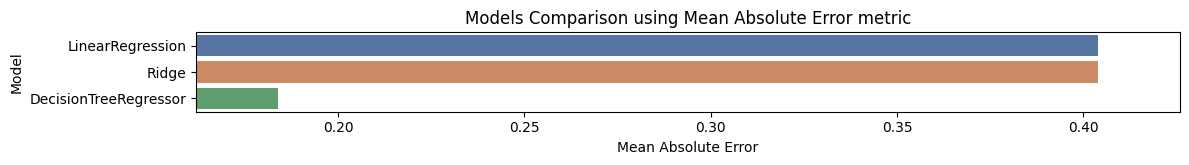

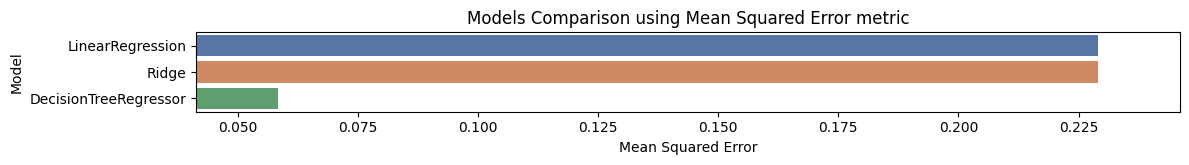

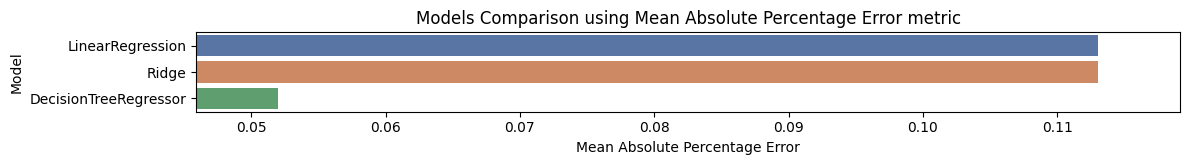

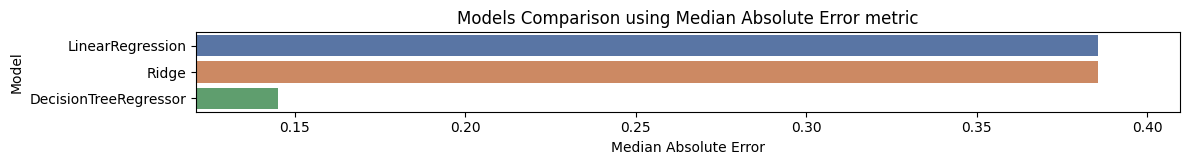

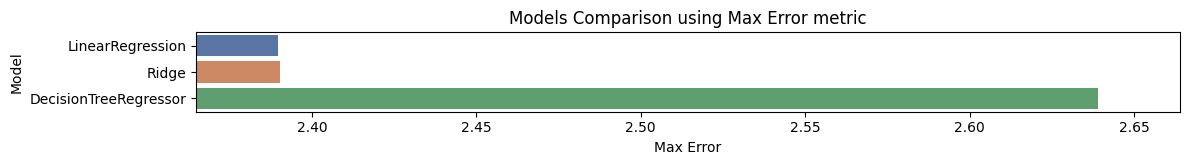

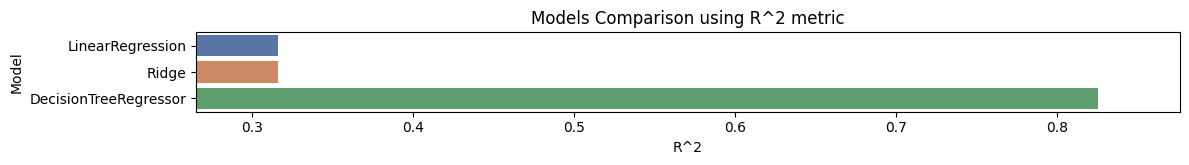

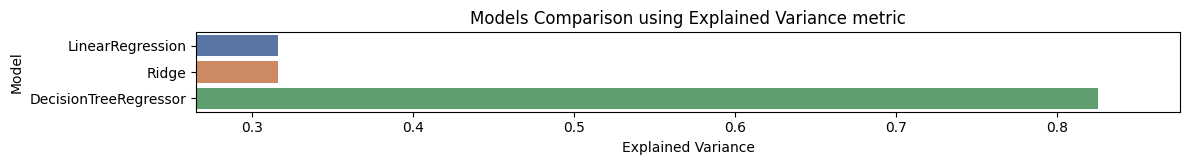

In [92]:
for metric in metrics:
    plot_bar_chart(models_result2, x=metric, y='Model', xlabel=metric, ylabel='Model', title=f"Models Comparison using {metric} metric")

In [93]:
best_models2 = get_best_model(models_result2, baseline_models, 'Mean Squared Error')
print('Best Model of Enhanced Features Models is:', best_models2.__class__.__name__)

Best Model of Enhanced Features Models is: DecisionTreeRegressor


In [94]:
del train_model2, test_model2, X_selected, X, y, X_train, X_test, y_train, y_test, X_train_test_model2

# Outlier Detection and Treatment

In [95]:
df_dtypes(train)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"
1,object,1,['date']


In [96]:
train_model3 = train.copy()
test_model3  = test.copy()

In [97]:
train_model3, _ = drop_id_feature(train_model3)
test_model3, _  = drop_id_feature(test_model3)

In [98]:
encode_str_features(train_model3)
encode_str_features(test_model3)
df_dtypes(train)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"
1,object,1,['date']


In [99]:
train_model3 = train_model3.drop(columns=train_model3.select_dtypes(exclude=[np.number]).columns)
test_model3  = test_model3.drop(columns=test_model3.select_dtypes(exclude=[np.number]).columns)
df_dtypes(train_model3)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"


In [100]:
def plot_feature_with_outlier(df, plot_func, outliers_indices, outliers_methods, x_col, y_col):
    for i in range(len(outliers_methods)):
        fig, ax = plt.subplots(1, 2, figsize=(12*2, 4))
        ax[0].set_title('Original Data')
        ax[1].set_title(f'Data without Outliers of {y_col} using {outliers_methods[i].__name__}')
        plot_func(x=x_col, y=y_col, ax=ax[0], data=df)
        plot_func(x=x_col, y=y_col, ax=ax[1], data=df.drop(outliers_indices[i]))
        plt.tight_layout()
        plt.show()

In [101]:
def outliers_iqr(df, col):
    outliers = pd.DataFrame()
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
    outliers = df.index[outliers]
    return outliers

def outliers_zscore(df, col, threshold=3):
    outliers = pd.DataFrame()
    z_scores = np.abs((df[col] - np.mean(df[col])) / np.std(df[col]))
    outliers = z_scores > threshold
    outliers = df.index[outliers]
    return outliers

In [102]:
def detect_outliers(df, target_feature, outliers_method):
    outliers_indices = [item for item in outliers_method(df, target_feature)]
    return outliers_indices

In [103]:
def plot_feature_with_outlier_methods(df, target_feature, outliers_methods, plot_func):
    outliers = [0] * len(outliers_methods)
    for i in range(len(outliers_methods)):
        outliers[i] = detect_outliers(df, target_feature, outliers_methods[i])
        print(f'length of {target_feature} outliers_indices: {len(outliers[i])} using {outliers_methods[i].__name__}')
    if sum(len(curr_outliers) for curr_outliers in outliers) == 0:
        return
    for curr_col in df.columns:
        if curr_col == target_feature:
            continue
        plot_feature_with_outlier(df, plot_func, outliers, outliers_methods, x_col=curr_col, y_col=target_feature)

In [104]:
def outlier_summary(df, method1, method2):
    numerical_features = get_numerical_features(df)
    df = df[numerical_features]
    outlier_info = pd.DataFrame({
        '#':        np.arange(len(df.columns)),
        'column':   df.columns,
        'dtype':    compute_dtype(df),
        'count':    compute_count(df),
        'mean':     compute_mean(df, numerical_features),
        'std':      compute_std(df, numerical_features),
        'min':      compute_min(df, numerical_features),
        '25%':      compute_quantile(df, numerical_features, .25),
        '50%':      compute_quantile(df, numerical_features, .5),
        '75%':      compute_quantile(df, numerical_features, .75),
        'max':      compute_max(df, numerical_features),
        'IQR':      compute_IQR(df, numerical_features),

        f'{method1.__name__}':  [list(method1(df, col)) for col in numerical_features],
        f'{method2.__name__}':  [list(method2(df, col)) for col in numerical_features],
    })

    outlier_info[f'{method1.__name__} length']  = outlier_info[f'{method1.__name__}'].apply(len)
    outlier_info[f'{method2.__name__} length']  = outlier_info[f'{method2.__name__}'].apply(len)

    if outlier_info[f'{method1.__name__} length'].shape[0] == 0 or \
       outlier_info[f'{method2.__name__} length'].shape[0] == 0:
        outlier_info['all_indices'] = pd.Series([set() for _ in range(len(outlier_info))], 
                                                index=outlier_info.index, dtype='object')
    else:
        outlier_info['all_indices'] = outlier_info.apply(lambda x:set(x[f'{method1.__name__}']) & \
                                                                  set(x[f'{method2.__name__}']), axis=1)
    outlier_info['all_indices length'] = outlier_info['all_indices'].apply(len)
    
    outlier_info = outlier_info.sort_values(by='all_indices length', ascending=False)
    outlier_info = outlier_info[outlier_info['all_indices length'] > 0]
    return outlier_info

In [105]:
outlier_info = outlier_summary(train_model3, outliers_iqr, outliers_zscore)
outlier_info.drop(columns=['outliers_iqr', 'outliers_zscore', 'all_indices'])

,#,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,outliers_iqr length,outliers_zscore length,all_indices length
1,1,sales,int64,913000,52.3,28.8,0,30.0,47.0,70.0,231,231,11967,6975,6975


In [106]:
def get_outlier_indices(outlier_info, method1, method2):
    col = 'all_indices'
    all_indices = set()
    for curr_indices in outlier_info[col]:
        all_indices |= curr_indices
    outlier_percentage = round(len(all_indices) / outlier_info['count'].max() * 100, 1)
    print(f'Total indices among all numerical features are: {len(all_indices)} ({outlier_percentage} %) of the dataset')
    return list(all_indices)

In [107]:
outlier_indices = get_outlier_indices(outlier_info, outliers_iqr, outliers_zscore)

Total indices among all numerical features are: 6975 (0.8 %) of the dataset


length of sales outliers_indices: 11967 using outliers_iqr
length of sales outliers_indices: 6975 using outliers_zscore


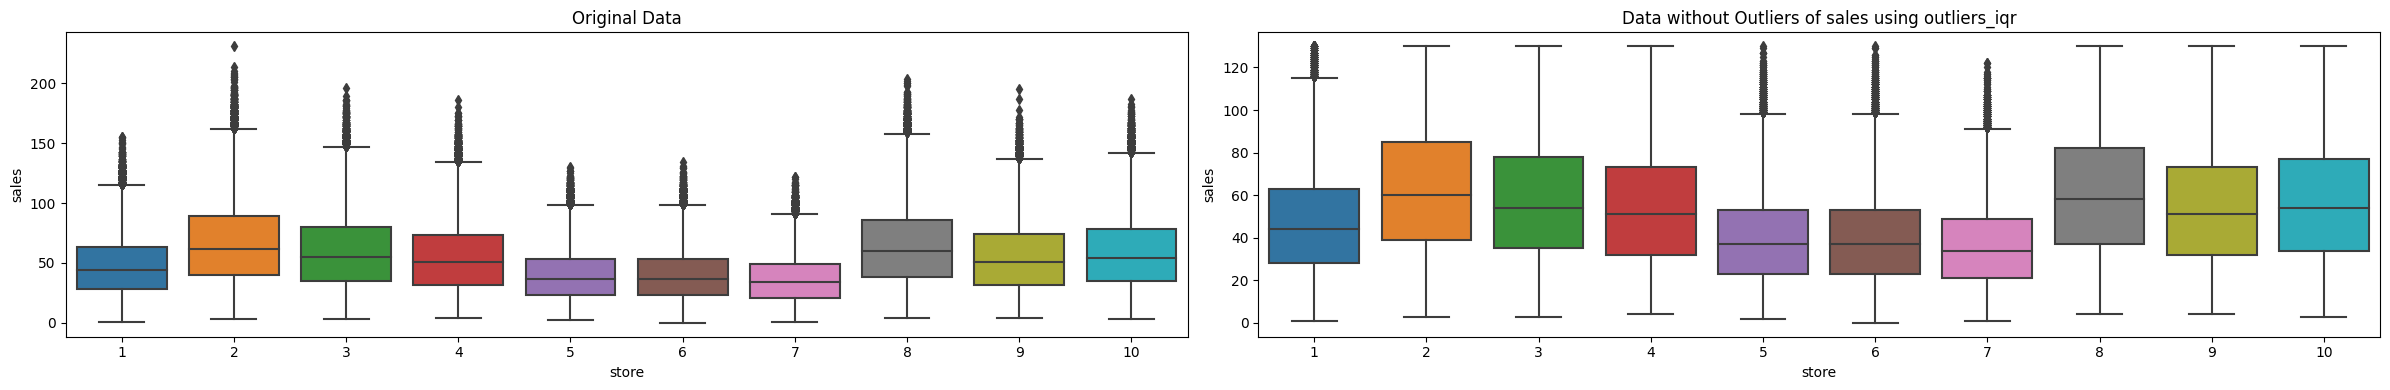

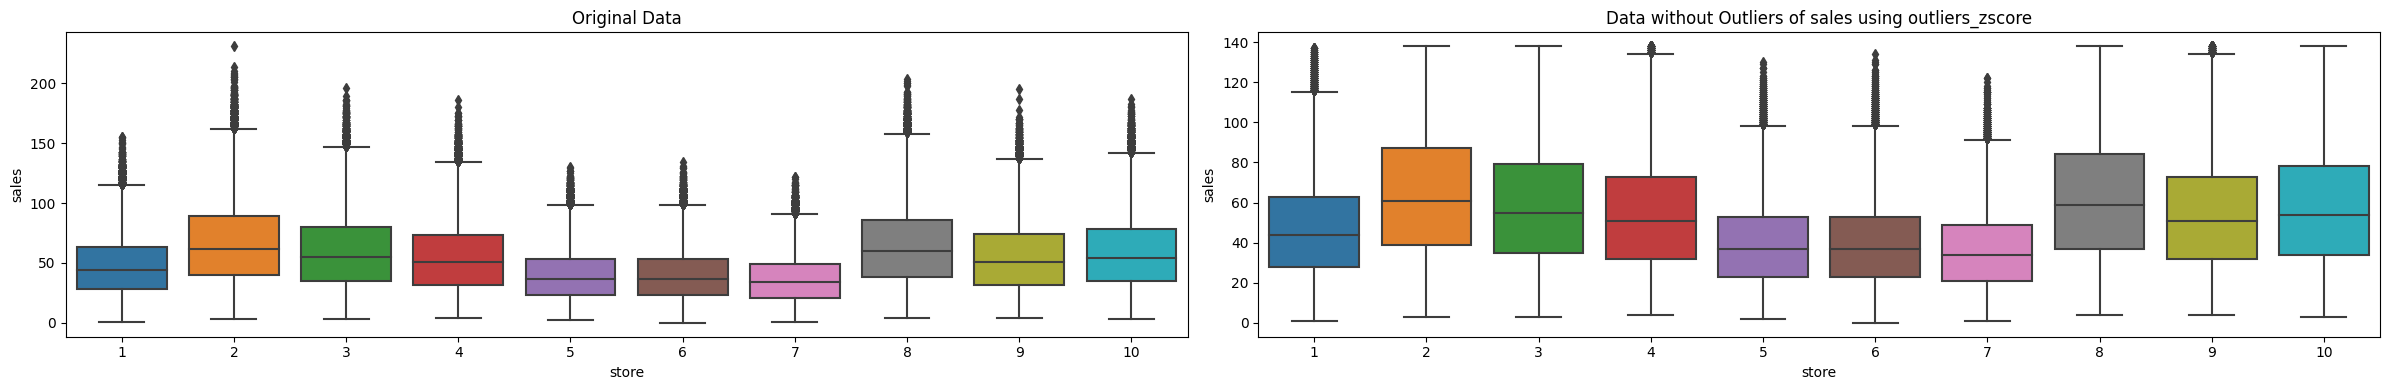

In [108]:
plot_feature_with_outlier_methods(train_model3[[categorical_features[0]]+[target_feature]], target_feature, [outliers_iqr, outliers_zscore], sns.boxplot)

In [109]:
print('Dataset shape before drop the outliers', train_model3.shape)
train_model3 = train_model3.drop(index=outlier_indices)
print('Dataset shape after drop the outliers ', train_model3.shape)

Dataset shape before drop the outliers (913000, 3)
Dataset shape after drop the outliers  (906025, 3)


# Outlier Treatment Model

In [110]:
df_dtypes(train_model3)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"


In [111]:
replace_inf(train_model3)
replace_inf(test_model3)
fillna(train_model3)
fillna(test_model3)

In [112]:
X_train, X_test, y_train, y_test = split_data_train_test(train_model3, target_feature)

In [113]:
models_result3 = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.0 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.0 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.01 minutes


In [114]:
models_result3

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,LinearRegression,22.437517,759.680183,0.665651,20.214982,88.977965,0.002995,0.003027
1,Ridge,22.437517,759.680183,0.665651,20.214982,88.977965,0.002995,0.003027
2,DecisionTreeRegressor,11.611036,230.978518,0.270257,8.984386,70.037879,0.696864,0.696868


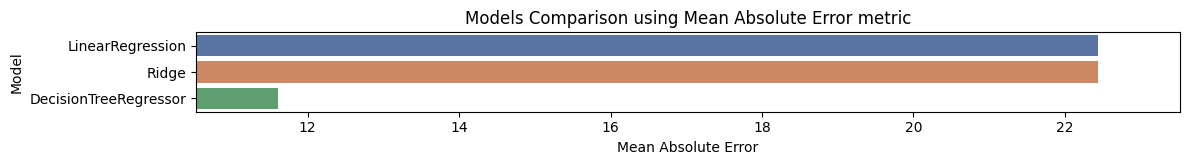

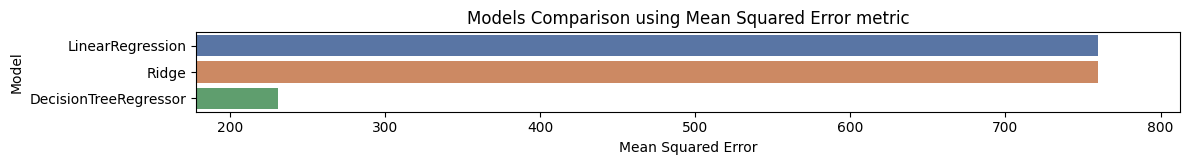

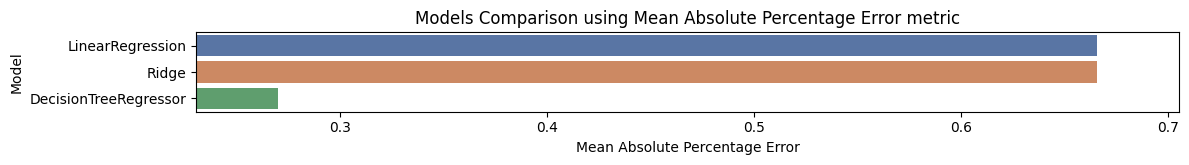

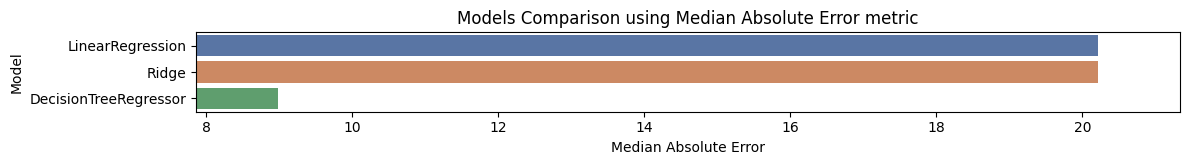

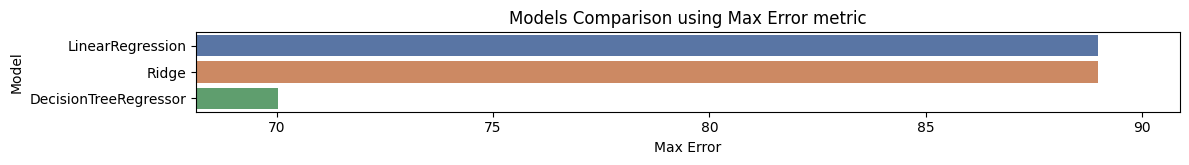

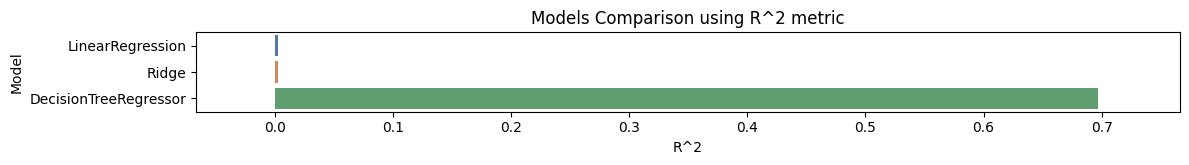

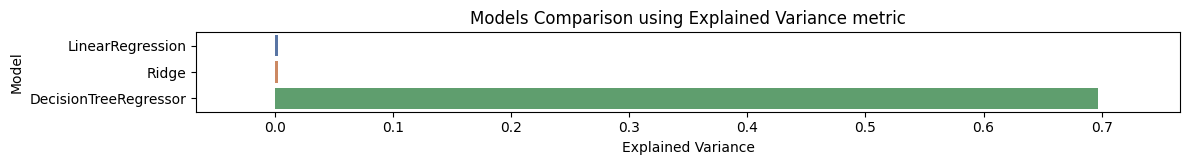

In [115]:
for metric in metrics:
    plot_bar_chart(models_result3, x=metric, y='Model', xlabel=metric, ylabel='Model', title=f"Models Comparison using {metric} metric")

In [116]:
best_models3 = get_best_model(models_result3, baseline_models, 'Mean Squared Error')
print('Best Model of Outlier Treatment Models is:', best_models3.__class__.__name__)

Best Model of Outlier Treatment Models is: DecisionTreeRegressor


In [117]:
del train_model3, test_model3, X_train, X_test, y_train, y_test

# Imbalanced Data Detection and Treatment

In [118]:
df_dtypes(train)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"
1,object,1,['date']


In [119]:
train_model6 = train.copy()
test_model6  = test.copy()

In [120]:
train_model6, _ = drop_id_feature(train_model6)
test_model6, _  = drop_id_feature(test_model6)

In [121]:
encode_str_features(train_model6)
encode_str_features(test_model6)
df_dtypes(train_model6)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"
1,object,1,['date']


In [122]:
train_model6 = train_model6.drop(columns=train_model6.select_dtypes(exclude=[np.number]).columns)
test_model6  = test_model6.drop(columns=test_model6.select_dtypes(exclude=[np.number]).columns)
df_dtypes(train_model6)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"


In [123]:
from collections import Counter
from imblearn.over_sampling import SMOTE

def oversampling_imbalanced_data(df, target_feature, k_neighbors=5):
    if k_neighbors >= min(Counter(df[target_feature]).values()):
        return df
    X = df.drop(target_feature, axis=1)
    y = df[target_feature]
    oversampler = SMOTE(k_neighbors=k_neighbors)
    X_resampled, y_resampled = oversampler.fit_resample(X, y)
    df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), 
                              pd.DataFrame(y_resampled, columns=[target_feature])], axis=1)
    return df_resampled

In [124]:
def plot_imbalanced_feature(df, df_resampled, target_feature):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.countplot(x=df[target_feature])
    plt.title('Class Distribution Before Oversampling')
    plt.xlabel(target_feature)
    plt.subplot(1, 2, 2)
    sns.countplot(x=df_resampled[target_feature])
    plt.title('Class Distribution After Oversampling')
    plt.xlabel(target_feature)

    plt.tight_layout()
    plt.show()

In [125]:
def plot_imbalanced_features(df, features):
    for col in features:
        if df[col].nunique() == 1:
            continue
        df_resampled = oversampling_imbalanced_data(df, col)
        if df.shape != df_resampled.shape:
            print(f'col: {col}, df.shape: {df.shape}, df_resampled.shape: {df_resampled.shape}')
            plot_imbalanced_feature(df, df_resampled, col)

In [126]:
def oversampling_data(df, features):
    for col in features:
        if df[col].nunique() == 1:
            continue
        df_resampled = oversampling_imbalanced_data(df, col)
        df = df_resampled.copy()
    return df

In [127]:
oversamplying_features = get_categorical_features(train_model6.select_dtypes(exclude=['float']), 4)
build_my_info_table(train_model6[oversamplying_features])

,#,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,nunique,unique,mode,mode #,mode %,null #,null %


In [128]:
plot_imbalanced_features(train_model6, oversamplying_features)

# Imbalanced Data Treatment Model

In [129]:
df_dtypes(train_model6)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"


In [130]:
replace_inf(train_model6)
replace_inf(train_model6)
fillna(train_model6)
fillna(train_model6)

In [131]:
X_train, X_test, y_train, y_test = split_data_train_test(train_model6, target_feature)

In [132]:
models_result6 = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.0 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.0 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.01 minutes


In [133]:
models_result6

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,LinearRegression,23.086237,825.196330,0.676935,20.584778,146.804471,0.003622,0.003626
1,Ridge,23.086237,825.196330,0.676935,20.584778,146.804471,0.003622,0.003626
2,DecisionTreeRegressor,11.886735,250.725655,0.271046,9.010338,92.263441,0.697263,0.697263


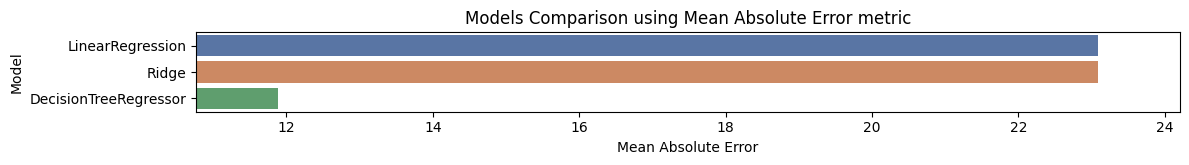

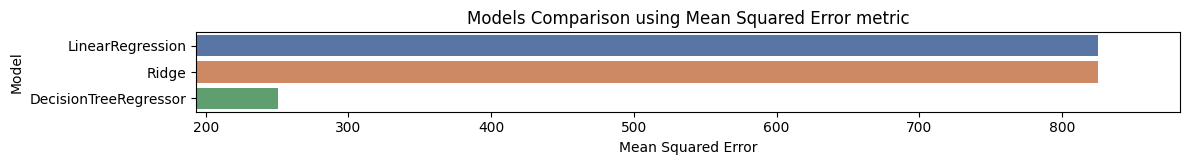

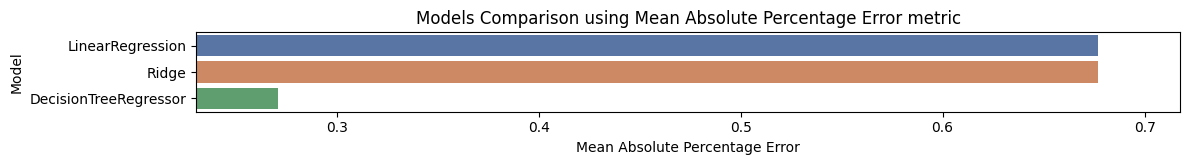

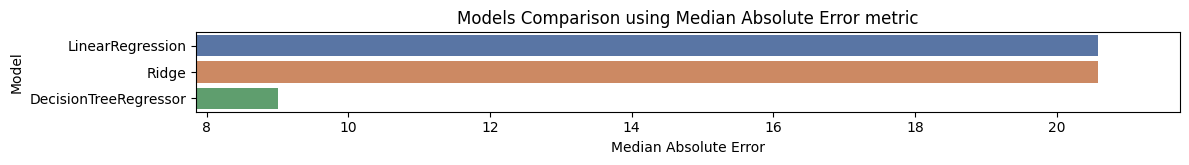

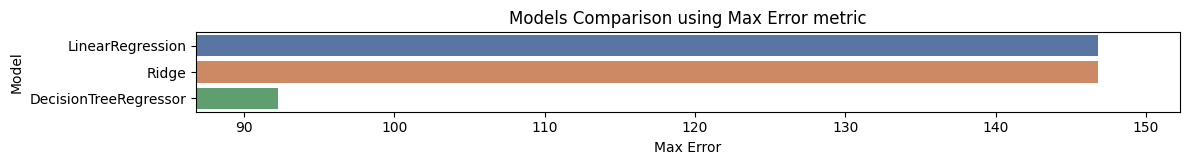

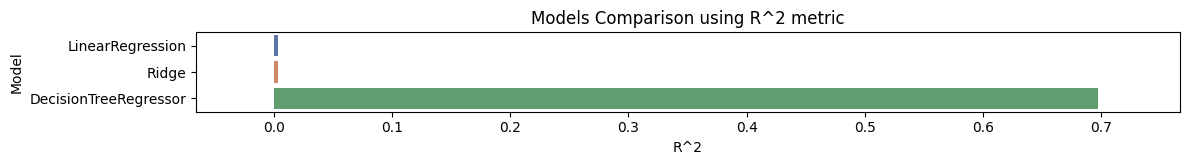

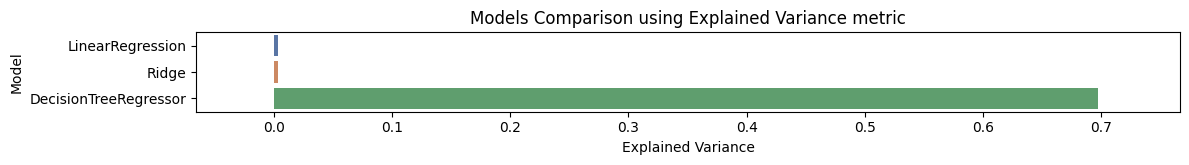

In [134]:
for metric in metrics:
    plot_bar_chart(models_result6, x=metric, y='Model', xlabel=metric, ylabel='Model', title=f"Models Comparison using {metric} metric")

In [135]:
best_models6 = get_best_model(models_result6, baseline_models, 'Mean Squared Error')
print('Best Model of Imbalanced Data Treatment Models is:', best_models6.__class__.__name__)

Best Model of Imbalanced Data Treatment Models is: DecisionTreeRegressor


In [136]:
del train_model6, test_model6, X_train, X_test, y_train, y_test

# Combine All Enhancements

In [137]:
df_dtypes(train)

,dtype,# columns,columns
0,int64,3,"['store', 'item', 'sales']"
1,object,1,['date']


In [138]:
train_model4 = train.copy()
test_model4  = test.copy()

In [139]:
train_model4, train_id = drop_id_feature(train_model4)
test_model4,  test_id  = drop_id_feature(test_model4)

In [140]:
extract_date(train_model4, 'date')
extract_date(test_model4, 'date')
add_columns(train_model4)
add_columns(test_model4)
df_dtypes(train_model4)

,dtype,# columns,columns
0,datetime64[ns],1,['date']
1,int64,14,"['store', 'item', 'sales', 'year date', 'month date', 'day date', 'day of week date', 'week of year date', 'quarter date', 'is weekend date', 'is leap year date', 'is_month_end date', 'is_month_start date', 'days_from_start']"
2,object,1,['store_item']


In [141]:
encode_str_features(train_model4)
encode_str_features(test_model4)
df_dtypes(train_model4)

,dtype,# columns,columns
0,datetime64[ns],1,['date']
1,int64,14,"['store', 'item', 'sales', 'year date', 'month date', 'day date', 'day of week date', 'week of year date', 'quarter date', 'is weekend date', 'is leap year date', 'is_month_end date', 'is_month_start date', 'days_from_start']"
2,object,1,['store_item']


In [142]:
outlier_info = outlier_summary(train_model4, outliers_iqr, outliers_zscore)
outlier_indices = get_outlier_indices(outlier_info, outliers_iqr, outliers_zscore)

Total indices among all numerical features are: 6975 (0.8 %) of the dataset


In [143]:
print('Dataset shape before drop the outliers', train_model4.shape)
train_model4 = train_model4.drop(index=outlier_indices)
print('Dataset shape after drop the outliers ', train_model4.shape)

Dataset shape before drop the outliers (913000, 16)
Dataset shape after drop the outliers  (906025, 16)


In [144]:
train_model4 = train_model4.drop(columns=train_model4.select_dtypes(exclude=[np.number]).columns)
test_model4  = test_model4.drop(columns=test_model4.select_dtypes(exclude=[np.number]).columns)
df_dtypes(train_model4)

,dtype,# columns,columns
0,int64,14,"['store', 'item', 'sales', 'year date', 'month date', 'day date', 'day of week date', 'week of year date', 'quarter date', 'is weekend date', 'is leap year date', 'is_month_end date', 'is_month_start date', 'days_from_start']"


In [145]:
oversamplying_features = get_categorical_features(train_model4.select_dtypes(exclude=['float']), 4)
build_my_info_table(train_model4[oversamplying_features])

,#,column,dtype,count,mean,std,min,25%,50%,75%,max,IQR,nunique,unique,mode,mode #,mode %,null #,null %
0,0,is weekend date,int64,906025,0.3,0.5,0,0.0,0.0,1.0,1,1,2,"[0, 1]",0,650092,71.8,0,0.0
1,1,is leap year date,int64,906025,0.2,0.4,0,0.0,0.0,0.0,1,1,2,"[0, 1]",0,725272,80.0,0,0.0
2,2,is_month_end date,int64,906025,0.0,0.2,0,0.0,0.0,0.0,1,1,2,"[0, 1]",0,876221,96.7,0,0.0
3,3,is_month_start date,int64,906025,0.0,0.2,0,0.0,0.0,0.0,1,1,2,"[1, 0]",0,876245,96.7,0,0.0


col: is weekend date, df.shape: (906025, 14), df_resampled.shape: (1300184, 14)


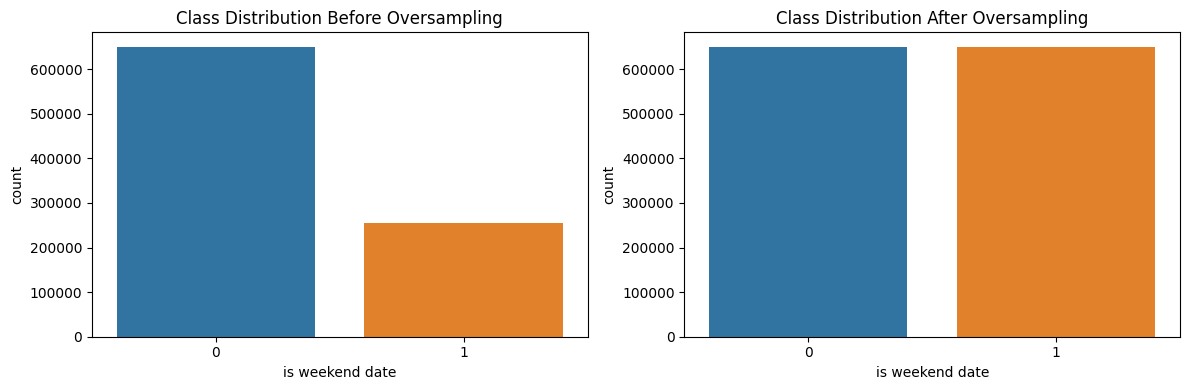

col: is leap year date, df.shape: (906025, 14), df_resampled.shape: (1450544, 14)


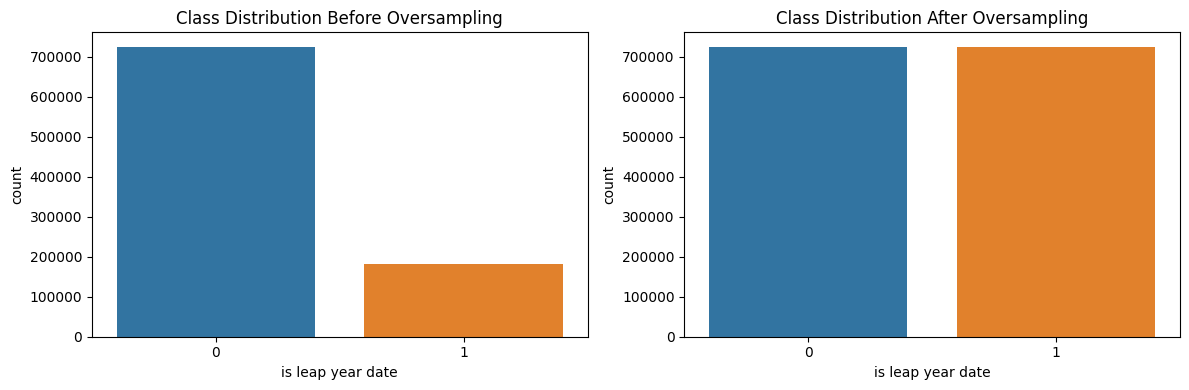

col: is_month_end date, df.shape: (906025, 14), df_resampled.shape: (1752442, 14)


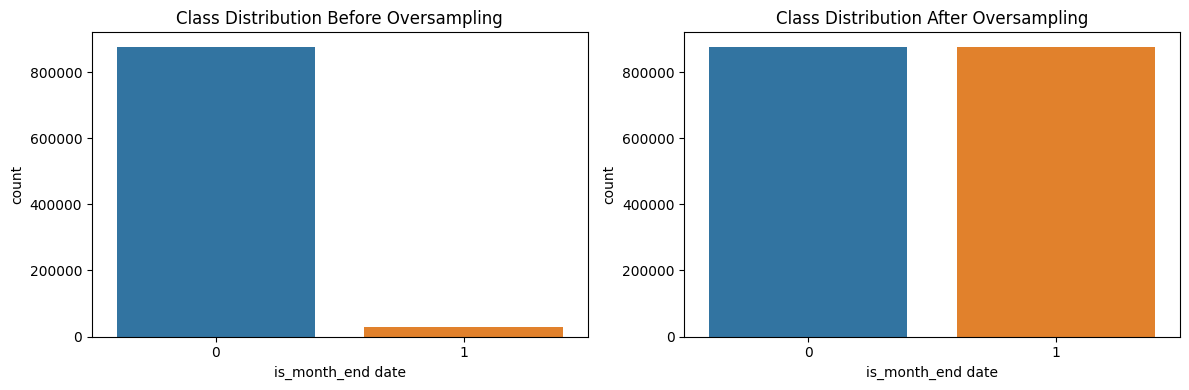

col: is_month_start date, df.shape: (906025, 14), df_resampled.shape: (1752490, 14)


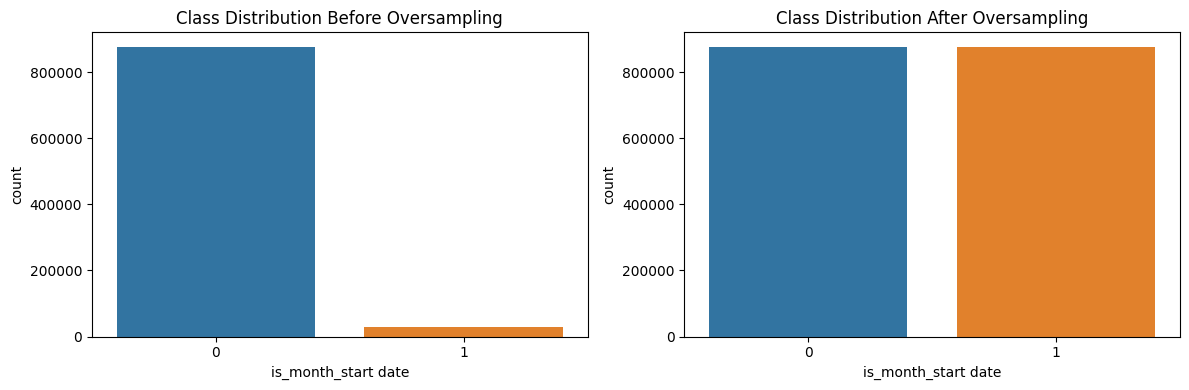

In [146]:
plot_imbalanced_features(train_model4, oversamplying_features)

In [147]:
print('Dataset shape before apply the oversampling', train_model4.shape)
train_model4 = oversampling_data(train_model4, oversamplying_features)
print('Dataset shape after apply the oversampling ', train_model4.shape)

Dataset shape before apply the oversampling (906025, 14)
Dataset shape after apply the oversampling  (7991724, 14)


In [148]:
skewed_features, non_skewed_features, skew_df = get_skewed_features(train_model4)
print(f'skewed_features:     {len(skewed_features)}\n{skewed_features}\n')
print(f'non_skewed_features: {len(non_skewed_features)}\n{non_skewed_features}\n')

skewed_features:     3
['sales', 'day date', 'days_from_start']

non_skewed_features: 2
['item', 'week of year date']



In [149]:
transform_skewed_features(train_model4, skewed_features)
transform_non_skewed_features(test_model4, non_skewed_features)
transform_skewed_features(train_model4, skewed_features)
transform_non_skewed_features(test_model4, non_skewed_features)

# Combine All Enhancements Model

In [150]:
df_dtypes(train_model4)

,dtype,# columns,columns
0,int64,11,"['store', 'item', 'year date', 'month date', 'day of week date', 'week of year date', 'quarter date', 'is weekend date', 'is leap year date', 'is_month_end date', 'is_month_start date']"
1,float64,3,"['sales', 'day date', 'days_from_start']"


In [151]:
replace_inf(train_model4)
replace_inf(test_model4)
fillna(train_model4)
fillna(test_model4)

In [152]:
X, y = split_data_X_y(train_model4, target_feature)

In [153]:
#importance_df = feature_selection(train_model4, mutual_info_regression)

In [154]:
selected_features = importance_df['Feature']
X_selected  = X[selected_features]
test_model4 = test_model4[selected_features]
df_dtypes(X_selected)

,dtype,# columns,columns
0,int64,9,"['item', 'store', 'month date', 'week of year date', 'quarter date', 'day of week date', 'year date', 'is weekend date', 'is leap year date']"
1,float64,1,['days_from_start']


In [155]:
X_train_test_model4 = pd.concat([X_selected, test_model4])
X_train_test_model4 = one_hot_encoding(X_train_test_model4)
X_selected  = X_train_test_model4[:len(X_selected)]
test_model4 = X_train_test_model4[-len(test_model4):]
df_dtypes(X_selected)

,dtype,# columns,columns
0,float64,39,"['item', 'days_from_start', 'week of year date', 'store_2', 'store_3', 'store_4', 'store_5', 'store_6', 'store_7', 'store_8', 'store_9', 'store_10', 'month date_2', 'month date_3', 'month date_4', 'month date_5', 'month date_6', 'month date_7', 'month date_8', 'month date_9', 'month date_10', 'month date_11', 'month date_12', 'quarter date_2', 'quarter date_3', 'quarter date_4', 'day of week date_1', 'day of week date_2', 'day of week date_3', 'day of week date_4', 'day of week date_5', 'day of week date_6', 'year date_2014', 'year date_2015', 'year date_2016', 'year date_2017', 'year date_2018', 'is weekend date_1', 'is leap year date_1']"


In [156]:
X_train, X_test, y_train, y_test = split_data_train_test(pd.concat([X_selected, y], axis=1), target_feature)

In [157]:
models_result4 = run_models(baseline_models, X_train, X_test, y_train, y_test)

Model LinearRegression begining now ...
Model LinearRegression run in                      0.28 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.04 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 0.94 minutes


In [158]:
models_result4

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,LinearRegression,0.086152,0.010827,3.999657e+09,0.079191,1.419494,0.260855,0.260855
1,Ridge,0.086152,0.010827,3.999659e+09,0.079191,1.419494,0.260855,0.260855
2,DecisionTreeRegressor,0.045578,0.004667,3.581674e+09,0.027965,1.271150,0.681412,0.681412


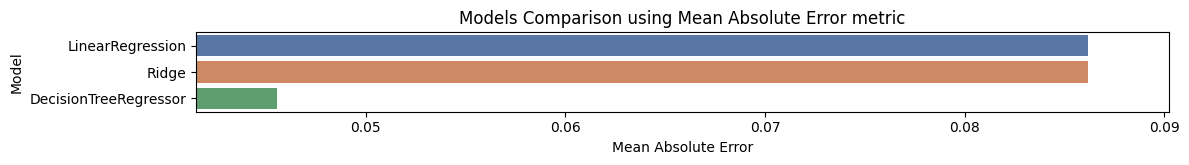

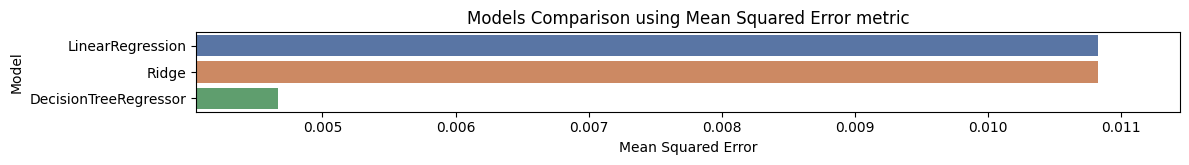

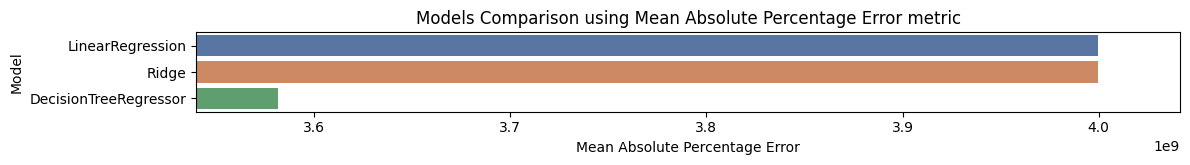

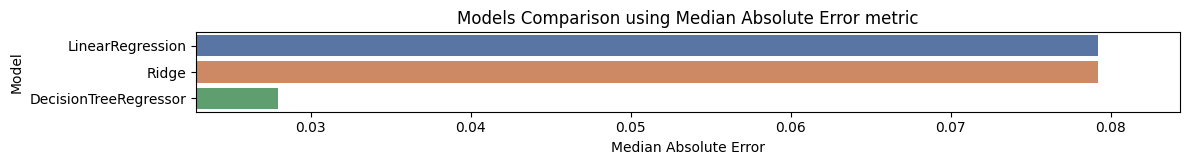

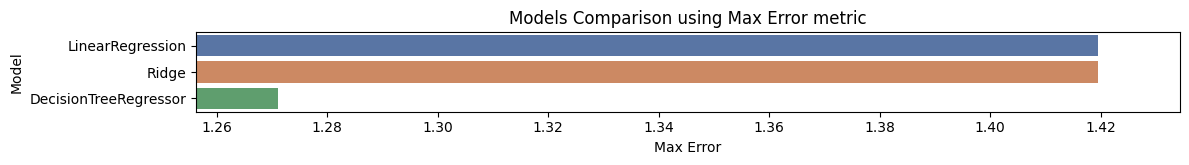

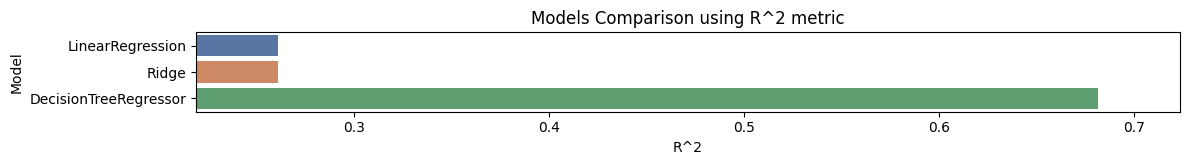

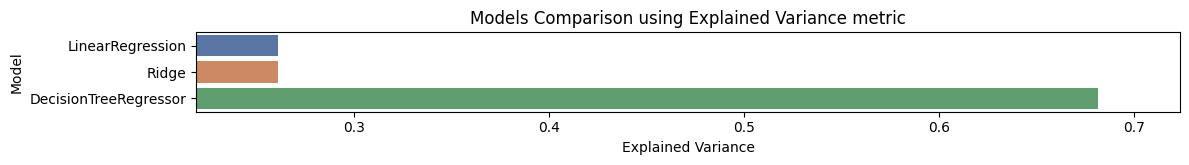

In [159]:
for metric in metrics:
    plot_bar_chart(models_result4, x=metric, y='Model', xlabel=metric, ylabel='Model', title=f"Models Comparison using {metric} metric")

In [160]:
best_models4 = get_best_model(models_result4, baseline_models, 'Mean Squared Error')
print('Best Model of Combine All Enhancements Models is:', best_models4.__class__.__name__)

Best Model of Combine All Enhancements Models is: DecisionTreeRegressor


# Business Insights

In [161]:
def plot_top_n(df, xlabel, ylabel, n=25, figsize=(12, 4)):
    plt.figure(figsize=figsize)
    sns.barplot(x=df.index, y=df)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    yminlim = df.min()
    ymaxlim = df.max()
    yrange = (ymaxlim - yminlim) * .05
    yminlim -= yrange
    ymaxlim += yrange
    plt.ylim(yminlim, ymaxlim)
    plt.title(f'Top {n} {xlabel} based on the {ylabel}')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [162]:
def plot_single_feature_analysis(df, features, n=5):
    for col in features:
        top_artists = df.groupby(col)[target_feature].mean().sort_values(ascending=False)
        plot_top_n(top_artists.head(n), col, f'mean of {target_feature}', n)

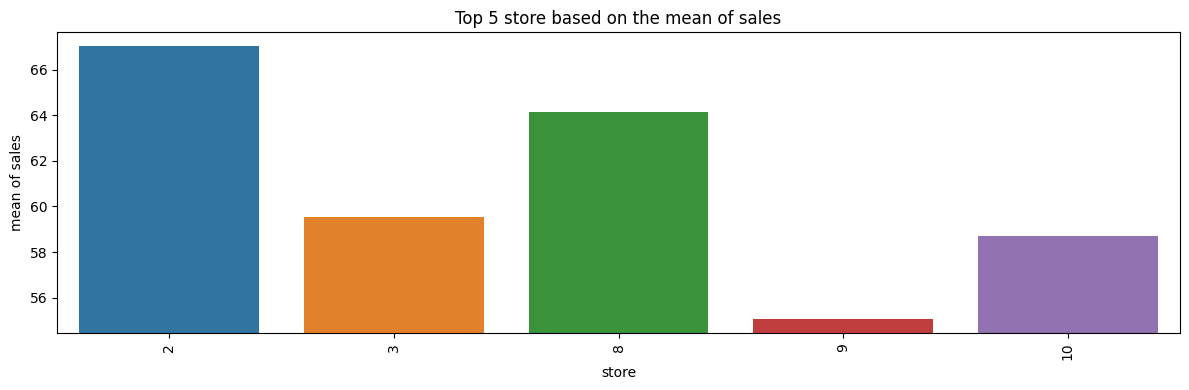

In [163]:
plot_single_feature_analysis(train, categorical_features)

In [164]:
def plot_multiple_feature_analysis(df, columns, plot_func, y_col, size=(12, 4), n_col=1):
    if len(columns) == 0:
        return
    n_rows = (len(columns) + n_col-1) // n_col
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0]*n_col, size[1]*n_rows))
    if len(columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, label in enumerate(columns):
        plot_func(df[df[y_col] >= df[y_col].median()], x=label, kde=True, color='green', label='Above Median', element='step', alpha=0.5, ax=axes[i])
        plot_func(df[df[y_col] <  df[y_col].median()], x=label, kde=True, color='red',   label='Below Median', element='step', alpha=0.5, ax=axes[i])
        axes[i].set_xlabel(label)
        axes[i].set_title(f'Above Median vs. Below Median {y_col} for {label}')

    for j in range(i+1, n_rows*n_col):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

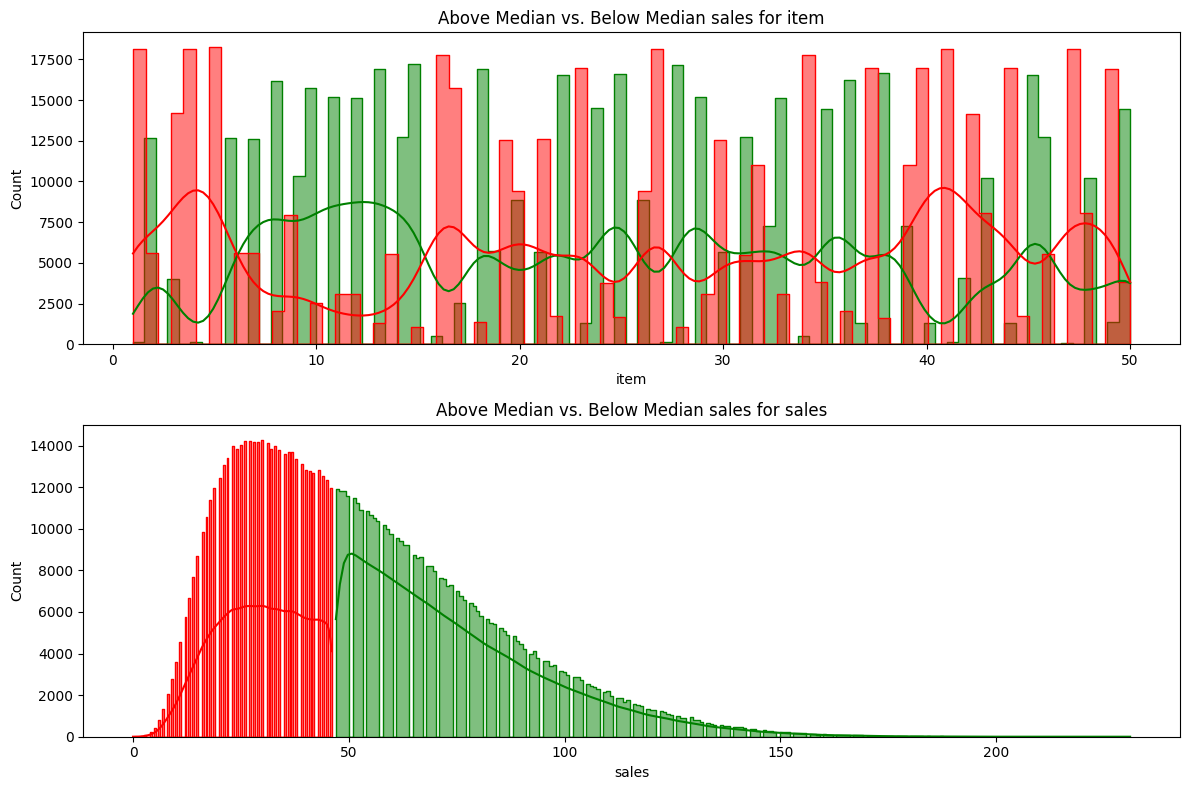

In [165]:
plot_multiple_feature_analysis(train, numerical_features, sns.histplot, target_feature)

# Other Predictive Models

In [166]:
X_selected5 = X_selected.copy()
test_model5 = test_model4.copy()

In [167]:
del train_model4, test_model4, X_selected, X_train, X_test, y_train, y_test, X_train_test_model4

In [168]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.impute          import SimpleImputer
from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import OneHotEncoder

In [169]:
def get_preprocessor(df):
    numerical_features   = df.select_dtypes(include=[np.number]).columns
    categorical_features = df.select_dtypes(exclude=[np.number]).columns
    
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler',  StandardScaler())
    ])
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot',  OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline,   numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
    
    return preprocessor

In [170]:
preprocessor = get_preprocessor(X_selected5)
X_selected5   = pd.DataFrame(preprocessor.fit_transform(X_selected5))

In [171]:
preprocessor = get_preprocessor(test_model5)
test_model5  = pd.DataFrame(preprocessor.fit_transform(test_model5))

In [172]:
from sklearn.linear_model    import LinearRegression, \
                                    Ridge
from sklearn.ensemble        import RandomForestRegressor, \
                                    GradientBoostingRegressor, \
                                    AdaBoostRegressor, \
                                    ExtraTreesRegressor
from sklearn.svm             import SVR
from sklearn.tree            import DecisionTreeRegressor
from sklearn.neighbors       import KNeighborsRegressor
from xgboost                 import XGBRegressor
from lightgbm                import LGBMRegressor

models = {
    'XGBRegressor':              XGBRegressor(),
    'LGBMRegressor':             LGBMRegressor(verbose=-1),
    'LinearRegression':          LinearRegression(),
    'Ridge':                     Ridge(alpha=10),
    'DecisionTreeRegressor':     DecisionTreeRegressor(),
    'AdaBoostRegressor':         AdaBoostRegressor(),
}
#    'GradientBoostingRegressor': GradientBoostingRegressor(),
#    'ExtraTreesRegressor':       ExtraTreesRegressor(),
#    'KNeighborsRegressor':       KNeighborsRegressor(),
#    'RandomForestRegressor':     RandomForestRegressor(),
#    'SupportVectorRegressor':    SVR(),

In [173]:
from sklearn.metrics         import mean_absolute_error, \
                                    mean_squared_error, \
                                    mean_absolute_percentage_error, \
                                    median_absolute_error, \
                                    max_error, \
                                    r2_score, \
                                    explained_variance_score

def evaluate_model(y_tests, y_preds, kf):
    mae, mse, mape, medae, me, r2, ev = 0, 0, 0, 0, 0, 0, 0
    for y_test, y_pred in zip(y_tests, y_preds):
        mae   += mean_absolute_error(y_test, y_pred)
        mse   += mean_squared_error(y_test, y_pred)
        mape  += mean_absolute_percentage_error(y_test, y_pred)
        medae += median_absolute_error(y_test, y_pred)
        me    += max_error(y_test, y_pred)
        r2    += r2_score(y_test, y_pred)
        ev    += explained_variance_score(y_test, y_pred)

    result = {
        'Mean Absolute Error': mae / kf,
        'Mean Squared Error': mse / kf,
        'Mean Absolute Percentage Error': mape / kf,
        'Median Absolute Error': medae / kf,
        'Max Error': me / kf,
        'R^2': r2 / kf,
        'Explained Variance': ev / kf,
    }
    return result

In [174]:
def run_model(model, X, y, kf):
    kfold = KFold(n_splits=kf, shuffle=True, random_state=42)
    y_tests, y_preds = [], []

    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        y_tests.append(y_test)
        y_preds.append(y_pred)

    return y_tests, y_preds

In [175]:
import time

def run_models(models, X, y, kf=5):
    results = {}
    for name, model in models.items():
        print(f'Model {name} begining now ...')
        begin_time = time.time()
        y_tests, y_preds = run_model(model, X, y, kf)
        results[name] = evaluate_model(y_tests, y_preds, kf)
        end_time = time.time()
        duration = round((end_time - begin_time) / 60, 2)
        print(f'Model {name} run in'.ljust(50), f'{duration} minutes')
    results = pd.DataFrame(results).T
    results = results.reset_index()
    results = results.rename(columns={'index': 'Model'})
    return results

In [176]:
models_result5 = run_models(models, X_selected5, y)

Model XGBRegressor begining now ...
Model XGBRegressor run in                          5.63 minutes
Model LGBMRegressor begining now ...
Model LGBMRegressor run in                         5.79 minutes
Model LinearRegression begining now ...
Model LinearRegression run in                      1.54 minutes
Model Ridge begining now ...
Model Ridge run in                                 0.32 minutes
Model DecisionTreeRegressor begining now ...
Model DecisionTreeRegressor run in                 4.89 minutes
Model AdaBoostRegressor begining now ...
Model AdaBoostRegressor run in                     83.61 minutes


In [177]:
models_result5

,Model,Mean Absolute Error,Mean Squared Error,Mean Absolute Percentage Error,Median Absolute Error,Max Error,R^2,Explained Variance
0,XGBRegressor,0.054210,0.005452,6.629354e+08,0.039426,0.890041,0.627589,0.627589
1,LGBMRegressor,0.056406,0.005700,6.898934e+08,0.042399,0.906629,0.610658,0.610659
2,LinearRegression,0.086118,0.010820,7.998008e+08,0.079113,1.005700,0.260911,0.260911
3,Ridge,0.086105,0.010817,7.999318e+08,0.079146,1.006099,0.261125,0.261125
4,DecisionTreeRegressor,0.045572,0.004662,7.163347e+08,0.028020,1.010496,0.681546,0.681546
5,AdaBoostRegressor,0.102919,0.014696,7.144723e+08,0.099430,0.821499,-0.003946,0.300077


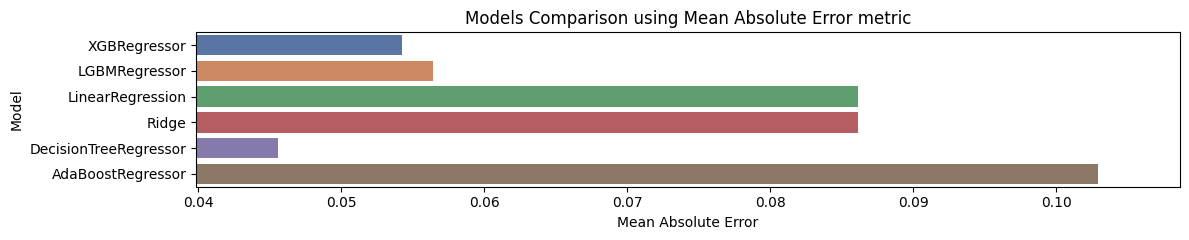

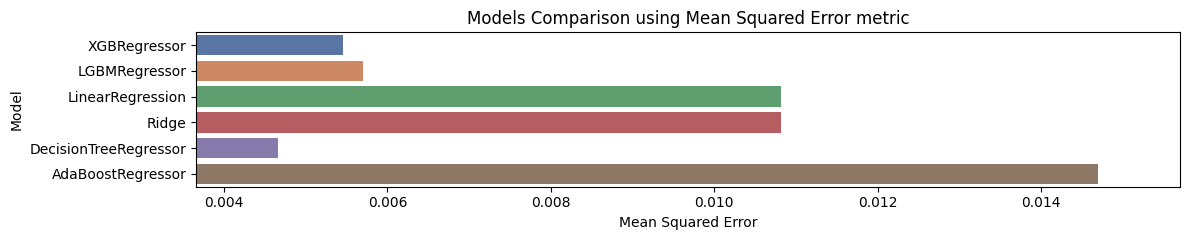

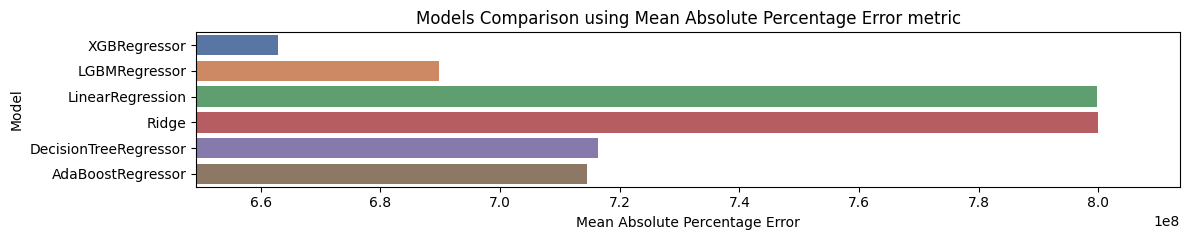

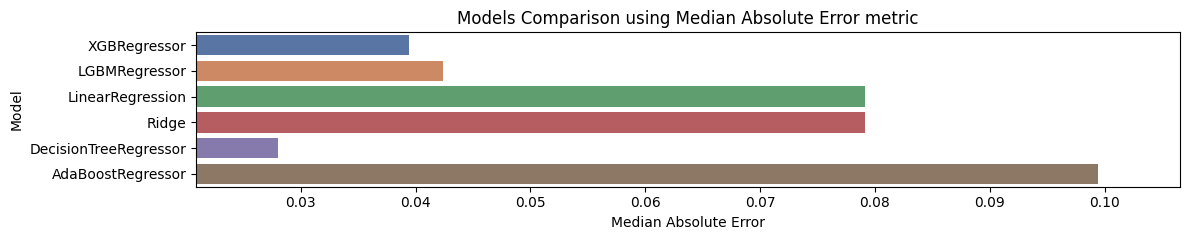

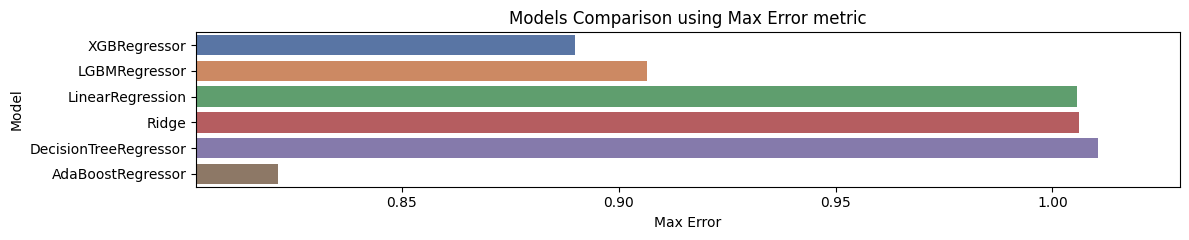

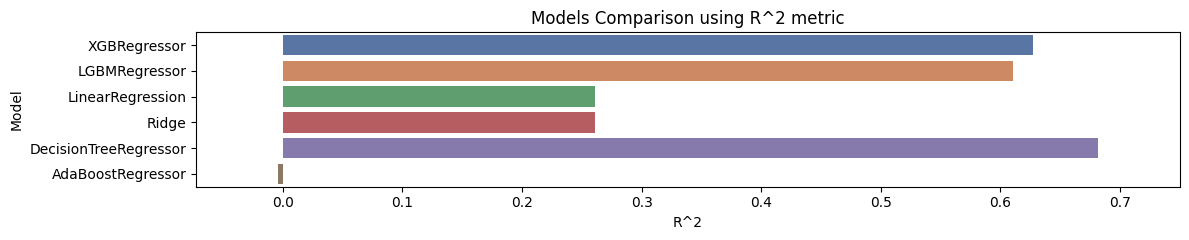

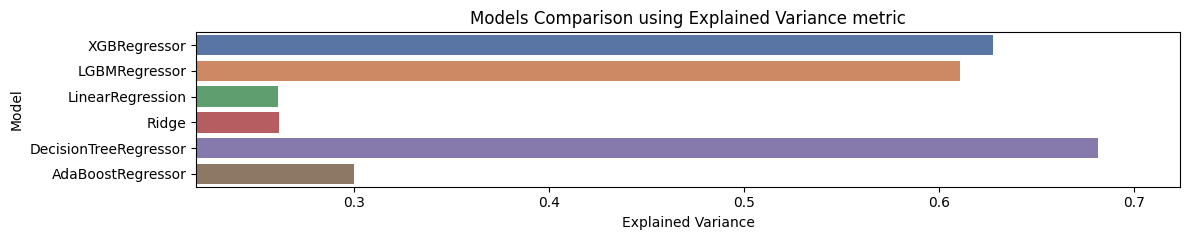

In [178]:
for metric in metrics:
    plot_bar_chart(models_result5, x=metric, y='Model', xlabel=metric, ylabel='Model', title=f"Models Comparison using {metric} metric")

In [179]:
best_models5 = get_best_model(models_result5, models, 'Mean Squared Error')
print('Best Model of Other Predictive Models is:', best_models5.__class__.__name__)

Best Model of Other Predictive Models is: DecisionTreeRegressor


# Submission

In [180]:
submission = pd.read_csv(f'{dir_path}/sample_submission.csv')
submission.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [181]:
submission = pd.DataFrame({
    'id' : test_id,
    target_feature : np.expm1(best_models5.predict(test_model5)),
})
submission.head()

,id,sales
0,0,2.833213
1,1,2.484907
2,2,2.308178
3,3,2.890372
4,4,2.564949


In [182]:
submission.to_csv("submission.csv", index = False, header = True)